# About
In recent years, Cloud Model 1 (CM1; http://www2.mmm.ucar.edu/people/bryan/cm1/) has become a very popular tool for performing idealized studies of atmospheric phenomena. There exists very little support for computing trajectories using CM1 output, which are usually necessary to understand the processes of the atmospheric phenomena of interest. Natively, CM1 only supports 'online' forward trajectories in 2D simulations and in 3D simulation without terrain. I wrote this script because there are no adequate tools available to compute highly customizable 'offline' trajectories in simulations with terrain. This script is intended to be easily customizable.

Notes:

* Can compute backward or forward trajectories (Default is backward, but can be forward with simple changes to "Calculate Trajectories" block)
* Written to work with 3D model output (can be modified to work with 2D output)
* Will work with or without terrain
* Initial location, number, and density of parcels can be easily specified in "Initialize Parcels" block
* Uses xarray and Dask to distribute memory and calculation across multiple processors
* With modifications, can be used with WRF output (several others have already done so)
* Comments that say "set by user" are specific to model output and desired trajectories

# Load Modules

In [1]:
%pylab inline
import os, sys
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
import time
import scipy.ndimage
import glob
import wrf as wrf
#%config IPCompleter.greedy=True

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!jupyter nbconvert --to script backwards_traj_fast_second_order_SDC_neu.ipynb

In [3]:
import nclcmaps as ncm
cma1=plt.get_cmap('bwr')
#cma2=coltbls.reflect()
cma3=plt.get_cmap('tab20c')
cma4=ncm.cmap("WhiteBlueGreenYellowRed")
cma5=plt.get_cmap('gray_r')

In [30]:
rc('mathtext', default='regular')
#matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['axes.facecolor'] = 'w'#[0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['patch.facecolor'] = 'w'
matplotlib.rcParams['hatch.linewidth'] = 0.25

# Read in CM1 Output

* User must insert path to data
    * If model output is one file use ***xr.open_dataset***
    * If model output is in multiple files use ***xr.openmfdataset***


In [37]:
#Use xarray to open model output and specify chunking if data set is large (set by user)
direc = "/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/"

fi_list0 = sorted(glob.glob(direc+"cm1out_0000[0-5]?.nc"))
#print(fi_list0)

fi_list1 = sorted(glob.glob(direc+"cm1out_00006[0-7].nc"))
#print(fi_list1)

#fi_list2 = sorted(glob.glob(direc+"cm1out_0000[7-9]?.nc"))
#print(fi_list2)

#fi_list3 = sorted(glob.glob(direc+"cm1out_0001[0-4]?.nc"))
#print(fi_list3)

#fi_list4 = sorted(glob.glob(direc+"cm1out_00013[0-1].nc"))
#print(fi_list4)

fi_list = fi_list0 + fi_list1 #+ fi_list2 + fi_list3 #+ fi_list4
print(fi_list)

['/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000001.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000002.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000003.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000004.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000005.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000006.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000007.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000008.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000009.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000010.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000011.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000012.nc', '/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/cm1out_000013.nc', '/glade/u/home/isingh9/scratch/cm119.

In [38]:
ds = xr.open_mfdataset(fi_list)#,chunks={'time': 1})
#ds2 = xr.open_mfdataset(fi_list2)#,chunks={'time': 1})

#Get model output dimensions
num_x = ds.nx #Number of gridpoints in x
num_y = ds.ny #Number of gridpoints in y
num_z = ds.nz #Number of gridpoints in z

x = np.arange(0,num_x,1)
y = np.arange(0,num_y,1)
z = np.arange(0,num_z,1)

print(ds)

/glade/work/isingh9/my_python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/glade/work/isingh9/my_python/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.Dataset>
Dimensions:     (ni: 1080, nip1: 1081, nj: 1080, njp1: 1081, nk: 110, nkp1: 111, one: 1, time: 67)
Coordinates:
  * time        (time) timedelta64[ns] 00:00:00 00:05:00 ... 05:25:00 05:30:00
Dimensions without coordinates: ni, nip1, nj, njp1, nk, nkp1, one
Data variables:
    f_cor       (time, one) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ztop        (time, one) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    xh          (time, ni) float32 dask.array<chunksize=(1, 1080), meta=np.ndarray>
    xf          (time, nip1) float32 dask.array<chunksize=(1, 1081), meta=np.ndarray>
    yh          (time, nj) float32 dask.array<chunksize=(1, 1080), meta=np.ndarray>
    yf          (time, njp1) float32 dask.array<chunksize=(1, 1081), meta=np.ndarray>
    z           (time, nk) float32 dask.array<chunksize=(1, 110), meta=np.ndarray>
    zf          (time, nkp1) float32 dask.array<chunksize=(1, 111), meta=np.ndarray>
    rain        (time, nj, ni) float32

In [39]:
ni = ds.dims['ni']
nj = ds.dims['nj']
nk = ds.dims['nk']
xh = ds.xh.values
yh = ds.yh.values
zh = ds.yh.values
zs = ds.zs.values

In [40]:
def extract_CM1_time(data_xarray): #
    year=data_xarray.year
    mon=data_xarray.month
    day=data_xarray.day
    hour=data_xarray.hour
    minute=data_xarray.minute
    second=data_xarray.second
    aa = data_xarray.time
    #print(aa)
    tiempo = (pd.to_datetime({'year':[year],'month': [mon],'day':[day],'hour':[hour],'minute':[minute],\
                          'second':[second]}, utc=True)) + aa.values
    return tiempo.dt.strftime("%Y-%m-%d %H:%M:%S")[0]+' UTC', tiempo.dt.strftime("%Y-%m-%d_%H-%M-%S")[0]


data1 = xr.open_dataset('/glade/u/home/isingh9/scratch/cm119.8_run_RW_LLJ_reduced_50_percent/'+'cm1out_000067.nc')

#data1 = xr.open_dataset(direc3+'cm1out_rst_000011.nc')
print(extract_CM1_time(data1))

('2018-11-10 17:00:00 UTC', '2018-11-10_17-00-00')


In [ ]:
#Option to use multiple processors and threads (set by user)
from dask.distributed import Client, LocalCluster
c = LocalCluster(n_workers=20, threads_per_worker=2)
client = Client(c)
client

# Initialize Parcels

User must enter desired trajectory characteristics

In [ ]:
print(len(fi_list))

In [8]:
#Number of parcels in vertical (can be more than number of vertical levels; set by user) 
num_seeds_z = 30#205

#Number of parcels in y (set by user) 
num_seeds_y = 250#300

#Number of parcels in x (set by user) 
num_seeds_x = 75#125

#Number of time steps to run trajectories back (set by user) 
time_steps = 61
incre = 1

#Time step to start backward trajectories at (set by user) 
start_time_step = 66

#Variable to record at each parcel's location throughout trajectory (code can be easily modified to add more; set by user) 
var_name1 = 'th'
var_name2 = 'qv'
var_name3 = 'prs'

#var_name4 = 'qvb_mp'
#var_name5 = 'qvb_pbl'

#var_name6 = 'ub_pbl'
#var_name7 = 'ub_pgrad'
#var_name8 = 'ub_cor'

#var_name9 = 'vb_pbl'
#var_name10 = 'vb_pgrad'
#var_name11 = 'vb_cor'

#var_name12 = 'wb_pgrad'
#var_name13 = 'wb_buoy'

#var_name14 = 'ptb_div'
#var_name15 = 'ptb_mp'
#var_name16 = 'ptb_pbl'
#var_name17 = 'ptb_rad'

#var_name18 = 'xvort'
#var_name19 = 'yvort'
#var_name20 = 'zvort'

#Set as 'Y' or 'N' for 'yes' or 'no' if the u, v, and w model output is on the staggered grid 
#(unless you have interpolated u, v, and w to the scalar grid, they are most likely on the staggered grid (set by user)
staggered = 'N'

**Model output info**

In [9]:
#Horizontal resolution of model output (meters)
hor_resolution = (ds.xf[0,1].values-ds.xf[0,0].values)*1000.0
#print('horizontal resolution is '+str(hor_resolution))
#Vertical resolution of model output (meters). Changes in x and y, if there is terrain, and z, if grid is stretched.
try:
    vert_resolution = ds.zh[0,1:,:,:].values-ds.zh[0,:-1,:,:].values
    #print('vertical resolution is '+str(vert_resolution))
    print('Output has terrain')
    
except:
    vert_res1d = (ds.z[1:].values-ds.z[:-1].values)*1000
    vert_res2d = np.repeat(vert_res1d,ds.ny, axis = 0).reshape(ds.nz-1, ds.ny)
    vert_resolution = np.repeat(vert_res2d,ds.nx, axis = 0).reshape(ds.nz-1, ds.ny, ds.nx)
    print('vertical resolution is '+str(vert_resolution))
    print('Output does not have terrain')
            
#Model output time step length (seconds)
time_step_length = (ds.time[1].values - ds.time[0].values)/np.timedelta64(1, 's')*incre
print('time step in seconds is '+str(time_step_length))

Output has terrain
time step in seconds is 300.0


**Create empty arrays to store x, y, and z positions of parcels**

In [10]:
xpos      = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #x-location (grid points on staggered grid)
print('size of xpos is ')
print(np.shape(xpos))
ypos      = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #y-location (grid points on staggered grid)
zpos      = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #z-location (grid points on staggered grid)
zpos_heightASL \
          = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #Height above sea level (meters)
zpos_vert_res  \
          = np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #Vertical grid spacing at parcel location (meters)
variable1 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable2 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable3 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
"""
variable4 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable5 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable6 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable7 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable8 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable9 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable10 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable11 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable12 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable13 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable14 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable15 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable16 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable17 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable18 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable19 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
variable20 =    \
            np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track
"""

size of xpos is 
(61, 30, 300, 125)


'\nvariable4 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable5 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable6 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable7 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable8 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable9 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable10 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvariable11 =                np.zeros((time_steps, num_seeds_z, num_seeds_y, num_seeds_x)) #User specified variable to track\nvar

**Initial location of parcels in gridpoints, specifically on the scalar grid (set by user). Initializes an array of parcels in the the y-z domain (modification necessary for x-dimension or 3D array of parcels)**

In [11]:
#x-position
for i in range(num_seeds_x):
    xpos[0,:,:,i] =  500 + i #This example initializes all seeds at same x-position (1000th x-grpt, set by user)

#y-position   
for i in range(num_seeds_y):
    ypos[0,:,i,:] =  400 + i  #This example initializes seeds evenly in y-dimension (0th, 4th, 8th, etc. y-grpt; set by user)

#z-position
for i in range(num_seeds_z):
    zpos[0,i,:,:] = i #This example initializes seeds evenly starting in z-dimension (0th, 1st, 2nd, etc., z-grpt; set by user)

## Determine Initial Height of Parcels Above Sea Level
Use the height of the models levels (meters above sea level) to convert from terrain following grid points to height above seal level.

In [12]:
#Get height of surface
try:
    zs = ds.zs[0,:,:].values
    print('Output has terrain')
except: 
    zs = np.zeros((ds.ny,ds.nx))
    print('Output does not have terrain')

#Get height of vertical coordinates (scalar grid)
try:
    zh = ds.zh[0,:,:,:].values
    print('Output has terrain')
except:
    zh1d = (ds.z[:].values)*1000
    zh2d = np.repeat(zh1d,ds.ny, axis = 0).reshape(ds.nz, ds.ny)
    zh = np.repeat(zh2d,ds.nx, axis = 0).reshape(ds.nz, ds.ny, ds.nx)
    print('Output does not have terrain')

#Create list of initial coordinates to get height
xloc = (xpos[0,:,:,:]).flatten()
yloc = (ypos[0,:,:,:]).flatten()
zloc = (zpos[0,:,:,:]).flatten()
coord_height = []
for i in range(len(xloc)):
    coord_height.append((zloc[i], yloc[i], xloc[i]))

#Get the actual inital height of the parcels in meters above sea level
zpos_heightASL[0,:,:] = np.reshape(interpolate.interpn((z,y,x), zh, coord_height, method='linear', bounds_error=False, fill_value= 0), (num_seeds_z, num_seeds_y, num_seeds_x))

Output has terrain
Output has terrain


KeyboardInterrupt: 

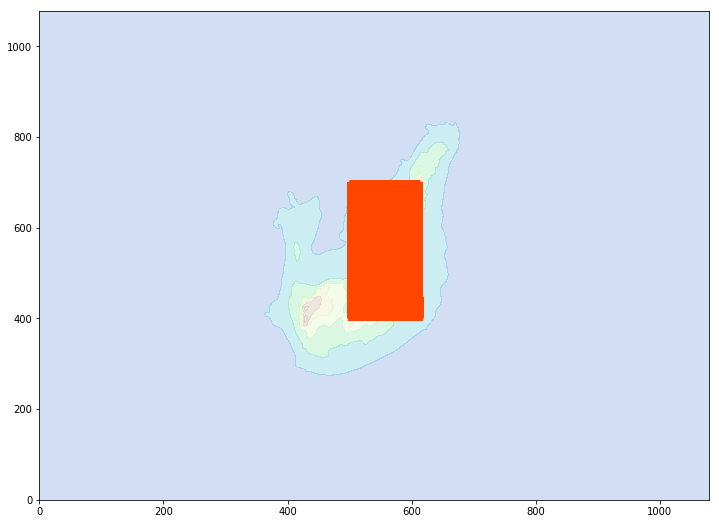

In [16]:
plt.figure(figsize=(12,9))
levels_terrain = np.arange(100.0,2400.0,100.0)
plt.contourf(ds.zs[30,:,:],cmap=plt.get_cmap('terrain'),alpha=0.2) #linewidths=0.75
#C1 = plt.contourf(ds.zs[0,:,:],levels_terrain,cmap="terrain",alpha=0.2)
                
for ii in range(num_seeds_x):
    for jj in range(num_seeds_y):
        plt.plot(xpos[0,1,jj,ii],ypos[0,1,jj,ii],color='orangered',lw=1,label='model lev 1',marker='*')

plt.xlabel('West-East distance (km)',fontsize=16)
plt.ylabel('North-south distance (km)',fontsize=16)
#plt.title('Trajectories: Top and Bottom',fontsize=22)
#plt.axvline(x=594,color='lime',linestyle='--',lw=2)
#matplotlib.rc('xtick', labelsize=16) 
#matplotlib.rc('ytick', labelsize=16) 
#plt.legend()
#plt.savefig('trajectories.png',dpi=200.)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xloc, yloc, zloc, c='r', marker='o',s=1)
#x = range(ni)
#y = range(nj)
#X, Y = np.meshgrid(x, y)

#ax.plot_surface(X,Y,np.flip(zs), rstride=10, cstride=10,cmap='viridis', edgecolor='none')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.plot_wireframe(X, Y, Z, color='black')
#print(ds.xh.values[0,-1])
ax.set_xlim([0,xh[0,-1]])
ax.set_ylim([0,yh[0,-1]])
print(yh)
#ax.set_xlim([0,zh[0,-1]])

ax.set_xlabel('X distance (km)')
ax.set_ylabel('Y distance (km)')
ax.set_zlabel('model level')

plt.show()
#ax.view_init(60, 90)
#fig

In [17]:
print("x-locations of particles are:")
#print(xloc)
print("y-locations of particles are:")
#print(yloc)
print("z-locations of particles are:")
#print(zloc)
print(zpos_heightASL)
print(coord_height)

x-locations of particles are:
y-locations of particles are:
z-locations of particles are:
[[[[1052.37341309 1056.75964355 1060.58666992 ...  423.50610352
     418.92175293  414.17041016]
   [1041.6126709  1045.21264648 1048.49279785 ...  424.48010254
     420.02191162  415.35186768]
   [1030.88562012 1033.78491211 1036.59240723 ...  425.79776001
     421.56756592  417.05950928]
   ...
   [ 243.12722778  243.95318604  245.05685425 ...  725.00476074
     711.05566406  697.35467529]
   [ 242.12995911  242.77615356  243.71636963 ...  729.16351318
     713.31506348  698.11810303]
   [ 241.38168335  241.87783813  242.6355896  ...  732.18859863
     714.5958252   698.0670166 ]]

  [[1148.51074219 1152.88000488 1156.69226074 ...  522.06677246
     517.50006104  512.76708984]
   [1137.79150391 1141.37756348 1144.64501953 ...  523.0369873
     518.5960083   513.94396973]
   [1127.10571289 1129.99389648 1132.79052734 ...  524.34960938
     520.13568115  515.64501953]
   ...
   [ 342.38299561  343

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Get variable data for final time step

# Calculate Trajectories
The method used to calculate trajectories is a second-order semi-implicit discretization in space and time. The method is described in depth in section 2.1 pf Miltenberger et al. 2013 (https://www.geosci-model-dev.net/6/1989/2013/gmd-6-1989-2013.pdf)
Unless user is changing trajectories from backwards to forwards, nothing should be changed here.

In [13]:
#Loop over all time steps and compute trajectory
for t in range(time_steps-1):
    print("no. of steps to be taken: "+str(time_steps))
    start = time.time() #Timer
    
    ##########################################################################################################
    ##########################################################################################################   
    ##################### Get data for 'first guess' step of integration scheme ##############################
    ##########################################################################################################
    ##########################################################################################################
    
    xmin = np.int(np.nanmin(xpos[t,:,:])-2)
    xmin = 0 if xmin < 0 else xmin
    
    xmax = np.int(np.nanmax(xpos[t,:,:])+2)
    xmax = ds.nx if xmax > ds.nx else xmax
    
    ymin = np.int(np.nanmin(ypos[t,:,:])-2)
    ymin = 0 if ymin < 0 else ymin
    
    ymax = np.int(np.nanmax(ypos[t,:,:])+2)
    ymax = ds.ny if ymax > ds.ny else ymax
    
    zmin = np.int(np.nanmin(zpos[t,:,:])-2)
    zmin = 0 if zmin < 0 else zmin
    
    zmax = np.int(np.nanmax(zpos[t,:,:])+2)
    zmax = ds.nz if zmax > ds.nz else zmax
    
    x_fast = np.arange(0,xmax-xmin)
    y_fast = np.arange(0,ymax-ymin)
    z_fast = np.arange(0,zmax-zmin)
    
    #Get model data
    t = np.int(t * incre)
    
    u = ds.uinterp[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    v = ds.vinterp[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    w = ds.winterp[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    
    var1 = getattr(ds,var_name1)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #th
    var2 = getattr(ds,var_name2)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #qv
    var3 = getattr(ds,var_name3)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #prs
    #var4 = getattr(ds,var_name4)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #qvb_mp
    #var5 = getattr(ds,var_name5)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values     #qvb_pbl
    
    #var6 = wrf.destagger(getattr(ds2,var_name6)[start_time_step-t,:,:,:],2,meta=True)
    #var6 = var6[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #ub_pbl
    #var7 = wrf.destagger(getattr(ds2,var_name7)[start_time_step-t,:,:,:],2,meta=True)
    #var7 = var7[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #ub_pgrad
    #var8 = wrf.destagger(getattr(ds2,var_name8)[start_time_step-t,:,:,:],2,meta=True)
    #var8 = var8[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #ub_cor
    

    #var9 = wrf.destagger(getattr(ds2,var_name9)[start_time_step-t,:,:,:],1,meta=True)
    #var9 = var9[zmin:zmax,ymin:ymax,xmin:xmax].values                                         #vb_pbl
    #var10 = wrf.destagger(getattr(ds2,var_name10)[start_time_step-t,:,:,:],1,meta=True)
    #var10 = var10[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #vb_pgrad
    #var11 = wrf.destagger(getattr(ds2,var_name11)[start_time_step-t,:,:,:],1,meta=True)
    #var11 = var11[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #vb_cor
    
    #var12 = wrf.destagger(getattr(ds2,var_name12)[start_time_step-t,:,:,:],0,meta=True)
    #var12 = var12[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #wb_pgrad
    #var13 = wrf.destagger(getattr(ds2,var_name13)[start_time_step-t,:,:,:],0,meta=True)
    #var13 = var13[zmin:zmax,ymin:ymax,xmin:xmax].values                                       #wb_buoy
    
    #var14 = getattr(ds2,var_name14)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_div
    #var15 = getattr(ds2,var_name15)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_mp
    #var16 = getattr(ds2,var_name16)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_pbl
    #var17 = getattr(ds2,var_name17)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #ptb_rad

    #var18 = getattr(ds,var_name18)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #xvort
    #var19 = getattr(ds,var_name19)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #yvort
    #var20 = getattr(ds,var_name20)[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values   #zvort

    
    t = np.int(t/incre) 
    
#     #Smooth data
#     smooth = 20
#     u = np.copy(scipy.ndimage.filters.uniform_filter(u, smooth))
#     v = np.copy(scipy.ndimage.filters.uniform_filter(v, smooth))
#     w = np.copy(scipy.ndimage.filters.uniform_filter(w, smooth))
    
    ############## Generate coordinates for interpolations ###############

    #x, y, and z on staggered and scalar grids
    xloc = np.copy(xpos[t,:,:]).flatten()-xmin
    xloc_stag = np.copy(xpos[t,:,:]+0.5).flatten()-xmin
    yloc = np.copy(ypos[t,:,:]).flatten()-ymin
    yloc_stag = np.copy(ypos[t,:,:]+0.5).flatten()-ymin
    zloc = np.copy(zpos[t,:,:]).flatten()-zmin
    zloc_stag = np.copy(zpos[t,:,:]+0.5).flatten()-zmin

    #If u, v, and w are staggered, generate three staggered sets of coordinates:
    #    1) u-grid (staggered in x)
    #    2) v-grid (staggered in y)
    #    3) w-grid (staggered in z)
    
    if staggered == 'Y':
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc_stag[i])) 
            coord_v.append((zloc[i], yloc_stag[i], xloc[i])) 
            coord_w.append((zloc_stag[i], yloc[i], xloc[i])) 
    
    #If not, generate scalar coordinates
    else: 
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc[i])) 
            coord_v.append((zloc[i], yloc[i], xloc[i])) 
            coord_w.append((zloc[i], yloc[i], xloc[i])) 
    
    #Scalar coordinates for all other variables
    coord = []
    coord_fast = []
    for i in range(len(xloc)):
        coord.append((zloc[i]+zmin, yloc[i]+ymin, xloc[i]+xmin)) 
        coord_fast.append((zloc[i], yloc[i], xloc[i])) 
    
    
    
    ##########################################################################################################   
    ########################## Integrate 'first guess' of parcel's new location ##############################
    ##########################################################################################################   

    
    #########################   Calc 'first guess' new xpos in grdpts   #######################################
    dx_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    xpos_1 = xpos[t,:,:] - dx_0

    #########################   Calc 'first guess' new ypos in grdpts   #######################################
    dy_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), v, coord_v, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    ypos_1 = ypos[t,:,:] - dy_0

    #########################   Calc 'first guess' new zpos in meters above sea level ######################################
    dz_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), w, coord_w, method='linear', bounds_error=False, fill_value= 0)*time_step_length, (num_seeds_z, num_seeds_y, num_seeds_x))
    zpos_heightASL_1 = zpos_heightASL[t,:,:] - dz_0
    
    ############# Convert zpos from meters above sea level to gridpts abve surface for interpolation #########
    #Get vertical grid spacing at each parcel's location
    zpos_vert_res[t,:,:] = np.reshape(interpolate.interpn((z[:-1],y,x), vert_resolution, coord, method='linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))


    #Calculate change in surface height and change in parcel height
    xloc = np.copy(xpos[t,:,:]).flatten()
    yloc = np.copy(ypos[t,:,:]).flatten()
    coord_zs1 = []
    for i in range(len(xloc)):
        coord_zs1.append((yloc[i], xloc[i]))
        
    xloc = np.copy(xpos_1).flatten()
    yloc = np.copy(ypos_1).flatten()
    coord_zs2 = []
    for i in range(len(xloc)):
        coord_zs2.append((yloc[i], xloc[i]))
    
    #Change in surface height over last timestep
    zs1 = interpolate.interpn((y,x), zs, coord_zs1, method='linear', bounds_error=False, fill_value= np.nan)
    zs2 = interpolate.interpn((y,x), zs, coord_zs2, method='linear', bounds_error=False, fill_value= np.nan)
    zs_change = zs2-zs1
    
    #Change in parcel height over last times step
    zpos_heightASL_change = zpos_heightASL_1.flatten()-zpos_heightASL[t,:,:].flatten()
    
    #Calculate zpos in grdpts above surface
    zpos_1 = zpos[t,:,:] + np.reshape((zpos_heightASL_change - zs_change)/zpos_vert_res[t,:,:].flatten(), (num_seeds_z, num_seeds_y, num_seeds_x))
    
    #Prevent parcels from going into the ground
    zpos_heightASL_1 = zpos_heightASL_1.clip(min=0)
    zpos_1 = zpos_1.clip(min=0)
    
    
    #Calculate value of variable at each parcel's location
    variable1[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var1, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    variable2[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var2, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    variable3[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var3, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable4[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var4, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable5[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var5, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable6[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var6, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable7[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var7, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable8[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var8, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable9[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var9, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable10[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var10, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))
    #variable11[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var11, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))##########################################################################################################
    #variable12[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var12, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable13[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var13, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable14[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var14, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable15[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var15, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable16[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var16, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))
    #variable17[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var17, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))##########################################################################################################
    #variable18[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var18, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x)) 
    #variable19[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var19, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))
    #variable20[t,:,:] = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), var20, coord_fast, method = 'linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))##########################################################################################################
    
    ##########################################################################################################   
    ##################### Get data for 'correction' step of integration scheme ###############################
    ##########################################################################################################
    ##########################################################################################################
    
    
    xmin = np.int(np.nanmin(xpos_1)-2)
    xmin = 0 if xmin < 0 else xmin
    
    xmax = np.int(np.nanmax(xpos_1)+2)
    xmax = ds.nx if xmax > ds.nx else xmax
    
    ymin = np.int(np.nanmin(ypos_1)-2)
    ymin = 0 if ymin < 0 else ymin
    
    ymax = np.int(np.nanmax(ypos_1)+2)
    ymax = ds.ny if ymax > ds.ny else ymax
    
    zmin = np.int(np.nanmin(zpos_1)-2)
    zmin = 0 if zmin < 0 else zmin
    
    zmax = np.int(np.nanmax(zpos_1)+2)
    zmax = ds.nz if zmax > ds.nz else zmax
    
    x_fast = np.arange(0,xmax-xmin)
    y_fast = np.arange(0,ymax-ymin)
    z_fast = np.arange(0,zmax-zmin)
    
    #Get model data for next time step
    t = t + 1
    t = np.int(t * incre)
    
    u = ds.uinterp[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    v = ds.vinterp[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    w = ds.winterp[start_time_step-t,zmin:zmax,ymin:ymax,xmin:xmax].values
    
    t = np.int(t/incre)
    t = t - 1
    
#     #Smooth data
#     smooth = 20
#     u = np.copy(scipy.ndimage.filters.uniform_filter(u, smooth))
#     v = np.copy(scipy.ndimage.filters.uniform_filter(v, smooth))
#     w = np.copy(scipy.ndimage.filters.uniform_filter(w, smooth))
#     var1 = np.copy(scipy.ndimage.filters.uniform_filter(var1, smooth))
    
        
        
    ############## Generate coordinates for interpolations ###############

    #x, y, and z on staggered and scalar grids
    xloc = np.copy(xpos_1).flatten()-xmin
    xloc_stag = np.copy(xpos_1+0.5).flatten()-xmin
    yloc = np.copy(ypos_1).flatten()-ymin
    yloc_stag = np.copy(ypos_1+0.5).flatten()-ymin
    zloc = np.copy(zpos_1).flatten()-zmin
    zloc_stag = np.copy(zpos_1+0.5).flatten()-zmin

    #If u, v, and w are staggered, generate three staggered sets of coordinates:
    #    1) u-grid (staggered in x)
    #    2) v-grid (staggered in y)
    #    3) w-grid (staggered in z)
    
    if staggered == 'Y':
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc_stag[i])) 
            coord_v.append((zloc[i], yloc_stag[i], xloc[i])) 
            coord_w.append((zloc_stag[i], yloc[i], xloc[i])) 
    
    #If not, generate scalar coordinates
    else: 
        coord_u = []
        coord_v = []
        coord_w = []
        for i in range(len(xloc)):
            coord_u.append((zloc[i], yloc[i], xloc[i])) 
            coord_v.append((zloc[i], yloc[i], xloc[i])) 
            coord_w.append((zloc[i], yloc[i], xloc[i])) 
    
    #Scalar coordinates for all other variables
    coord = []
    coord_fast = []
    for i in range(len(xloc)):
        coord.append((zloc[i]+zmin, yloc[i]+ymin, xloc[i]+xmin)) 
        coord_fast.append((zloc[i], yloc[i], xloc[i])) 
    
    ##########################################################################################################   
    ########################## Integrate 'correction' of parcel's new location ###############################
    ##########################################################################################################   

    
    #########################   Calc 'correction' new xpos in grdpts   #######################################
    dx_1 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    xpos[t+1,:,:] = xpos[t,:,:] - (dx_0 + dx_1)/2

    #########################   Calc 'correction' new ypos in grdpts   #######################################
    dy_1 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), v, coord_v, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution, (num_seeds_z, num_seeds_y, num_seeds_x))
    ypos[t+1,:,:] = ypos[t,:,:] - (dy_0 + dy_1)/2

    #########################   Calc 'correction' new zpos in meters above sea level ######################################
    dz_1 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), w, coord_w, method='linear', bounds_error=False, fill_value= 0)*time_step_length, (num_seeds_z, num_seeds_y, num_seeds_x))
    zpos_heightASL[t+1,:,:] = zpos_heightASL[t,:,:] - (dz_0 + dz_1)/2
    
    
    
    ############# Convert zpos from meters above sea level to gridpts abve surface for interpolation #########
    #Get vertical grid spacing at each parcel's location
    zpos_vert_res[t,:,:] = np.reshape(interpolate.interpn((z[:-1],y,x), vert_resolution, coord, method='linear', bounds_error=False, fill_value= np.nan), (num_seeds_z, num_seeds_y, num_seeds_x))

    
    #Calculate change in surface height and change in parcel height
    xloc = np.copy(xpos[t,:,:]).flatten()
    yloc = np.copy(ypos[t,:,:]).flatten()
    coord_zs1 = []
    for i in range(len(xloc)):
        coord_zs1.append((yloc[i], xloc[i]))
        
    xloc = np.copy(xpos[t+1,:,:]).flatten()
    yloc = np.copy(ypos[t+1,:,:]).flatten()
    coord_zs2 = []
    for i in range(len(xloc)):
        coord_zs2.append((yloc[i], xloc[i]))
    
    #Change in surface height over last timestep
    zs1 = interpolate.interpn((y,x), zs, coord_zs1, method='linear', bounds_error=False, fill_value= np.nan)
    zs2 = interpolate.interpn((y,x), zs, coord_zs2, method='linear', bounds_error=False, fill_value= np.nan)
    zs_change = zs2-zs1
    
    #Change in parcel height over last times step
    zpos_heightASL_change = zpos_heightASL[t+1,:,:].flatten()-zpos_heightASL[t,:,:].flatten()
    
    #Calculate zpos in grdpts above surface
    zpos[t+1,:,:] = zpos[t,:,:] + np.reshape((zpos_heightASL_change - zs_change)/zpos_vert_res[t,:,:].flatten(), (num_seeds_z, num_seeds_y, num_seeds_x))
    

    ##########################################################################################################
    
    
    #Prevent parcels from going into the ground
    zpos = zpos.clip(min=0)
    zpos_heightASL = zpos_heightASL.clip(min=0)
    
    #Timer
    stop = time.time()
    print("Integration {:01d} took {:.2f} seconds".format(t, stop-start))

no. of steps to be taken: 61
Integration 0 took 42.75 seconds
no. of steps to be taken: 61
Integration 1 took 46.59 seconds
no. of steps to be taken: 61
Integration 2 took 48.40 seconds
no. of steps to be taken: 61
Integration 3 took 49.26 seconds
no. of steps to be taken: 61
Integration 4 took 49.63 seconds
no. of steps to be taken: 61
Integration 5 took 50.15 seconds
no. of steps to be taken: 61
Integration 6 took 50.33 seconds
no. of steps to be taken: 61
Integration 7 took 50.40 seconds
no. of steps to be taken: 61
Integration 8 took 50.48 seconds
no. of steps to be taken: 61
Integration 9 took 50.62 seconds
no. of steps to be taken: 61
Integration 10 took 51.06 seconds
no. of steps to be taken: 61
Integration 11 took 51.26 seconds
no. of steps to be taken: 61
Integration 12 took 51.27 seconds
no. of steps to be taken: 61
Integration 13 took 51.04 seconds
no. of steps to be taken: 61
Integration 14 took 51.28 seconds
no. of steps to be taken: 61
Integration 15 took 51.27 seconds
no

In [ ]:
print(shape(z_fast))
print(shape(y_fast))
print(shape(x_fast))
print(shape(u))
print(shape(coord_u))
print((num_seeds_z))
print((num_seeds_y))
print((num_seeds_x))
print(time_step_length)
print(hor_resolution)
print(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)*time_step_length/hor_resolution)
#dx_0 = np.reshape(interpolate.interpn((z_fast,y_fast,x_fast), u, coord_u, method='linear', bounds_error=False, fill_value=np.nan)

In [14]:
var_name1 = 'th'
var_name2 = 'qv'
var_name3 = 'prs'


np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_xpos_'+str(start_time_step)+'_'+str(time_steps), xpos)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_ypos_'+str(start_time_step)+'_'+str(time_steps), ypos)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_zpos_'+str(start_time_step)+'_'+str(time_steps), zpos_heightASL)

np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percent_th_traj_'+str(start_time_step)+'_'+str(time_steps), variable1)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percentqv_traj_'+str(start_time_step)+'_'+str(time_steps), variable2)
np.save('/glade/u/home/isingh9/jupyter_nbks/RW_LLJ_50_percentprs_traj_'+str(start_time_step)+'_'+str(time_steps), variable3)

# 50% LLJ reduced trajectories 

In [64]:
xpos=np.load('RW_LLJ_50_percent_xpos_66_61.npy')
ypos=np.load('RW_LLJ_50_percent_ypos_66_61.npy')
zpos=np.load('RW_LLJ_50_percent_zpos_66_61.npy')

th=np.load('RW_LLJ_50_percent_th_traj_66_61.npy')
qv=np.load('RW_LLJ_50_percentqv_traj_66_61.npy')
prs=np.load('RW_LLJ_50_percentprs_traj_66_61.npy')

In [65]:
xpos_xr=xr.DataArray(xpos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'xpos','long_name':'x-position','units':'km'})
ypos_xr=xr.DataArray(ypos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'ypos','long_name':'y-position','units':'km'})
zpos_xr=xr.DataArray(zpos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'zpos','long_name':'z-position','units':'km'})
th_xr=xr.DataArray(th,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'th','long_name':'potential temperature','units':'K'})
prs_xr=xr.DataArray(prs,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'prs','long_name':'pressure','units':'Pa'})
qv_xr=xr.DataArray(qv,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(400,700,1))\
                              ,('ni',np.arange(500,625,1))],attrs={'short_name':'qv','long_name':'mixing ratio','units':'kg/kg'})

# Save Trajectory Data
The x, y, and z positions and user-specified variable values are saved in 3D numpy arrays. The first dimension is time and the other two are the positions and values of variables of all the parcels at that specifc time.

In [4]:
var_name1 = 'th'
var_name2 = 'qv'
var_name3 = 'prs'

var_name4 = 'qvb_mp'
var_name5 = 'qvb_pbl'

var_name6 = 'ub_pbl'
var_name7 = 'ub_pgrad'
var_name8 = 'ub_cor'

var_name9 = 'vb_pbl'
var_name10 = 'vb_pgrad'
var_name11 = 'vb_cor'

var_name12 = 'wb_pgrad'
var_name13 = 'wb_buoy'

var_name14 = 'ptb_div'
var_name15 = 'ptb_mp'
var_name16 = 'ptb_pbl'
var_name17 = 'ptb_rad'

var_name18 = 'xvort'
var_name19 = 'yvort'
var_name20 = 'zvort'

np.save('/glade/u/home/isingh9/jupyter_nbks/xpos_'+str(start_time_step)+'_'+str(time_steps), xpos)
np.save('/glade/u/home/isingh9/jupyter_nbks/ypos_'+str(start_time_step)+'_'+str(time_steps), ypos)
np.save('/glade/u/home/isingh9/jupyter_nbks/zpos_'+str(start_time_step)+'_'+str(time_steps), zpos_heightASL)

np.save('/glade/u/home/isingh9/jupyter_nbks/th_traj_'+str(start_time_step)+'_'+str(time_steps), variable1)
np.save('/glade/u/home/isingh9/jupyter_nbks/qv_traj_'+str(start_time_step)+'_'+str(time_steps), variable2)
np.save('/glade/u/home/isingh9/jupyter_nbks/prs_traj_'+str(start_time_step)+'_'+str(time_steps), variable3)

np.save('/glade/u/home/isingh9/jupyter_nbks/qvb_mp_traj_'+str(start_time_step)+'_'+str(time_steps), variable4)
np.save('/glade/u/home/isingh9/jupyter_nbks/qvb_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable5)

np.save('/glade/u/home/isingh9/jupyter_nbks/ub_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable6)
np.save('/glade/u/home/isingh9/jupyter_nbks/ub_pgrad_traj_'+str(start_time_step)+'_'+str(time_steps), variable7)
np.save('/glade/u/home/isingh9/jupyter_nbks/ub_cor_traj_'+str(start_time_step)+'_'+str(time_steps), variable8)

np.save('/glade/u/home/isingh9/jupyter_nbks/vb_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable9)
np.save('/glade/u/home/isingh9/jupyter_nbks/vb_pgrad_traj_'+str(start_time_step)+'_'+str(time_steps), variable10)
np.save('/glade/u/home/isingh9/jupyter_nbks/vb_cor_traj_'+str(start_time_step)+'_'+str(time_steps), variable11)

np.save('/glade/u/home/isingh9/jupyter_nbks/wb_pgrad_traj_'+str(start_time_step)+'_'+str(time_steps), variable12)
np.save('/glade/u/home/isingh9/jupyter_nbks/wb_buoy_traj_'+str(start_time_step)+'_'+str(time_steps), variable13)

np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_div_traj_'+str(start_time_step)+'_'+str(time_steps), variable14)
np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_mp_traj_'+str(start_time_step)+'_'+str(time_steps), variable15)
np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_pbl_traj_'+str(start_time_step)+'_'+str(time_steps), variable16)
np.save('/glade/u/home/isingh9/jupyter_nbks/ptb_rad_traj_'+str(start_time_step)+'_'+str(time_steps), variable17)

np.save('/glade/u/home/isingh9/jupyter_nbks/xvort_traj_'+str(start_time_step)+'_'+str(time_steps), variable18)
np.save('/glade/u/home/isingh9/jupyter_nbks/yvort_traj_'+str(start_time_step)+'_'+str(time_steps), variable19)
np.save('/glade/u/home/isingh9/jupyter_nbks/zvort_traj_'+str(start_time_step)+'_'+str(time_steps), variable20)

NameError: name 'start_time_step' is not defined

In [ ]:
tyty=np.load('qv_traj_66_61.npy')
print(np.shape(tyty))

In [ ]:
plt.imshow(zpos[60,0,:,:])
plt.colorbar()

In [5]:
#ds = xr.open_dataset('terrain_height_cm1.nc')
#print(ds)

xpos=np.load('xpos_66_61.npy')
ypos=np.load('ypos_66_61.npy')
zpos=np.load('zpos_66_61.npy')

th=np.load('th_traj_66_61.npy')
qv=np.load('qv_traj_66_61.npy')
prs=np.load('prs_traj_66_61.npy')

qvb_pbl=np.load('qvb_pbl_traj_66_61.npy')
qvb_mp=np.load('qvb_mp_traj_66_61.npy')

ub_pbl=np.load('ub_pbl_traj_66_61.npy')
ub_pgrad=np.load('ub_pgrad_traj_66_61.npy')
ub_cor=np.load('ub_cor_traj_66_61.npy')

vb_pbl=np.load('vb_pbl_traj_66_61.npy')
vb_pgrad=np.load('vb_pgrad_traj_66_61.npy')
vb_cor=np.load('vb_cor_traj_66_61.npy')

wb_pgrad=np.load('wb_pgrad_traj_66_61.npy')
wb_buoy=np.load('wb_buoy_traj_66_61.npy')

ptb_div=np.load('ptb_div_traj_66_61.npy')
ptb_mp=np.load('ptb_mp_traj_66_61.npy')
ptb_pbl=np.load('ptb_pbl_traj_66_61.npy')
ptb_rad=np.load('ptb_rad_traj_66_61.npy')

xvort=np.load('xvort_traj_66_61.npy')
yvort=np.load('yvort_traj_66_61.npy')
zvort=np.load('zvort_traj_66_61.npy')


In [6]:
qvb_mp=qvb_mp+0.00000000001
ptb_mp=ptb_mp+0.00000000001

In [7]:
xpos_xr=xr.DataArray(xpos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'xpos','long_name':'x-position','units':'km'})
ypos_xr=xr.DataArray(ypos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ypos','long_name':'y-position','units':'km'})
zpos_xr=xr.DataArray(zpos,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'zpos','long_name':'z-position','units':'km'})
th_xr=xr.DataArray(th,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'th','long_name':'potential temperature','units':'K'})
prs_xr=xr.DataArray(prs,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'prs','long_name':'pressure','units':'Pa'})
qv_xr=xr.DataArray(qv,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'qv','long_name':'mixing ratio','units':'kg/kg'})


qvb_pbl_xr=xr.DataArray(qvb_pbl,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'qvb_pbl','long_name':'qv tendency: PBL term','units':'kg/kg/s'})
qvb_mp_xr=xr.DataArray(qvb_mp,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'qvb_mp','long_name':'qv tendency: Microphysics term','units':'kg/kg/s'})


ub_pbl_xr=xr.DataArray(ub_pbl,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ub_pbl','long_name':'u tendency: PBL term','units':'m/s/s'})
ub_pgrad_xr=xr.DataArray(ub_pgrad,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ub_pgrad','long_name':'u tendency: Pressure grad term','units':'m/s/s'})
ub_cor_xr=xr.DataArray(ub_cor,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ub_cor','long_name':'u tendency: Coriolis term','units':'m/s/s'})


vb_pbl_xr=xr.DataArray(vb_pbl,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'vb_pbl','long_name':'v tendency: PBL term','units':'m/s/s'})
vb_pgrad_xr=xr.DataArray(vb_pgrad,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'vb_pgrad','long_name':'v tendency: Pressure grad term','units':'m/s/s'})
vb_cor_xr=xr.DataArray(vb_cor,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'vb_cor','long_name':'v tendency: Coriolis term','units':'m/s/s'})


wb_pgrad_xr=xr.DataArray(wb_pgrad,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'wb_pgrad','long_name':'w tendency: Pressure grad term','units':'m/s/s'})
wb_buoy_xr=xr.DataArray(wb_buoy,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'wb_buoy','long_name':'w tendency: Buoyancy term','units':'m/s/s'})


ptb_div_xr=xr.DataArray(ptb_div,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ptb_div','long_name':'theta tendency: Divergence term','units':'K/s'})
ptb_mp_xr=xr.DataArray(ptb_mp,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ptb_mp','long_name':'theta tendency: Microphysics term','units':'K/s'})
ptb_pbl_xr=xr.DataArray(ptb_pbl,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ptb_pbl','long_name':'theta tendency: PBL term','units':'K/s'})
ptb_rad_xr=xr.DataArray(ptb_rad,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'ptb_rad','long_name':'theta tendency: Radiation term','units':'K/s'})


xvort_xr=xr.DataArray(xvort,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'xvort','long_name':'x-vorticity','units':'1/s'})
yvort_xr=xr.DataArray(yvort,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'yvort','long_name':'y-vorticity','units':'1/s'})
zvort_xr=xr.DataArray(zvort,coords=[('time',pd.date_range(end='2018-11-10 17:00:00',periods=61,freq='5min')),('nk',np.arange(0,30,1)),('nj',np.arange(300,800,2))\
                              ,('ni',np.arange(500,650,2))],attrs={'short_name':'zvort','long_name':'z-vorticity','units':'1/s'})

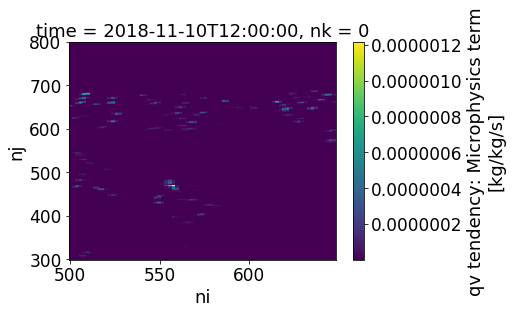

In [8]:
qvb_mp_xr[0,0,:,:].plot()

In [9]:
import metpy.calc as mcalc
from metpy.units import units

sp_hum =mcalc.specific_humidity_from_mixing_ratio(mixing_ratio=qv_xr.values * units('kg/kg'))
temp   =mcalc.temperature_from_potential_temperature(pressure=prs_xr.values * units('Pa'),theta=th_xr.values * units('K'))
dewpt  =mcalc.dewpoint_from_specific_humidity(specific_humidity=sp_hum,temperature=temp,pressure=prs_xr.values * units('Pa'))
theta_e=mcalc.equivalent_potential_temperature(pressure=prs_xr.values * units('Pa'),temperature=temp,dewpoint=dewpt)

thetae_xr=th_xr.copy()
thetae_xr.values=theta_e.magnitude
thetae_xr.attrs={'short_name':'theta_e','long_name':'Equivalent potential temperature','units':'K'}

/glade/work/isingh9/my_python/lib/python3.6/site-packages/pint/quantity.py:1494: RuntimeWarning: invalid value encountered in greater
  self._convert_magnitude_not_inplace(self.UnitsContainer()), other
/glade/work/isingh9/my_python/lib/python3.6/site-packages/pint/numpy_func.py:289: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/glade/work/isingh9/my_python/lib/python3.6/site-packages/pint/quantity.py:1164: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [10]:
qvb_total_xr=qvb_pbl_xr+qvb_mp_xr
qvb_total_xr.attrs={'short_name':'qvb_total','long_name':'qv tendency: Total','units':'kg/kg/s'}

ub_total_xr=ub_pbl_xr+ub_pgrad_xr+ub_cor_xr
ub_total_xr.attrs={'short_name':'ub_total','long_name':'u tendency: Total','units':'m/s/s'}

vb_total_xr=vb_pbl_xr+vb_pgrad_xr+vb_cor_xr
vb_total_xr.attrs={'short_name':'vb_total','long_name':'v tendency: Total','units':'m/s/s'}

wb_total_xr=wb_pgrad_xr+wb_buoy_xr
wb_total_xr.attrs={'short_name':'wb_total','long_name':'w tendency: Total','units':'m/s/s'}

ptb_total_xr=ptb_pbl_xr+ptb_div_xr+ptb_mp_xr+ptb_rad_xr
ptb_total_xr.attrs={'short_name':'ptb_total','long_name':'theta tendency: Total','units':'K/s'}


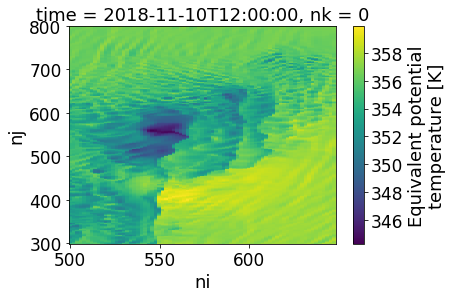

In [11]:
thetae_xr[0,0,:,:].plot()

In [25]:
import numpy.ma as ma

def separate_easterly_westerly_branches(XPOS_XARRAY,MAIN_XARRAY,LEVEL):
    
    xr_east=MAIN_XARRAY.copy()
    xr_west=MAIN_XARRAY.copy()

    xpos_all = XPOS_XARRAY.sel(nk=LEVEL).values
    
    xpos_east_temp=xpos_all[0,:,:]-xpos_all[10,:,:]
    xpos_west_temp=xpos_all[0,:,:]-xpos_all[10,:,:]
    
    xpos_east_temp=np.where(xpos_east_temp>=0.,True,xpos_east_temp)
    xpos_east_temp=np.where(xpos_east_temp<0.,False,xpos_east_temp)

    xpos_west_temp=np.where(xpos_west_temp>=0.,False,xpos_west_temp)
    xpos_west_temp=np.where(xpos_west_temp<0.,True,xpos_west_temp)
    
    mx_east = ma.masked_array(xr_east.values,mask=xr_east.values*xpos_east_temp[np.newaxis,np.newaxis,:,:])
    mx_west = ma.masked_array(xr_west.values,mask=xr_west.values*xpos_west_temp[np.newaxis,np.newaxis,:,:])

    xr_east.values=mx_east
    xr_west.values=mx_west
    
    xr_east.attrs['branch']='east'
    xr_west.attrs['branch']='west'
    
    return xr_east,xr_west

In [26]:
xpos_east_xr,xpos_west_xr=separate_easterly_westerly_branches(xpos_xr,xpos_xr,1)
ypos_east_xr,ypos_west_xr=separate_easterly_westerly_branches(xpos_xr,ypos_xr,1)
zpos_east_xr,zpos_west_xr=separate_easterly_westerly_branches(xpos_xr,zpos_xr,1)

qv_east_xr,qv_west_xr=separate_easterly_westerly_branches(xpos_xr,qv_xr,1)
th_east_xr,th_west_xr=separate_easterly_westerly_branches(xpos_xr,th_xr,1)
prs_east_xr,prs_west_xr=separate_easterly_westerly_branches(xpos_xr,prs_xr,1)

qvb_pbl_east_xr,qvb_pbl_west_xr=separate_easterly_westerly_branches(xpos_xr,qvb_pbl_xr,1)
qvb_mp_east_xr,qvb_mp_west_xr=separate_easterly_westerly_branches(xpos_xr,qvb_mp_xr,1)

ub_pbl_east_xr,ub_pbl_west_xr=separate_easterly_westerly_branches(xpos_xr,ub_pbl_xr,1)
ub_pgrad_east_xr,ub_pgrad_west_xr=separate_easterly_westerly_branches(xpos_xr,ub_pgrad_xr,1)
ub_cor_east_xr,ub_cor_west_xr=separate_easterly_westerly_branches(xpos_xr,ub_cor_xr,1)

vb_pbl_east_xr,vb_pbl_west_xr=separate_easterly_westerly_branches(xpos_xr,vb_pbl_xr,1)
vb_pgrad_east_xr,vb_pgrad_west_xr=separate_easterly_westerly_branches(xpos_xr,vb_pgrad_xr,1)
vb_cor_east_xr,vb_cor_west_xr=separate_easterly_westerly_branches(xpos_xr,vb_cor_xr,1)

wb_pgrad_east_xr,wb_pgrad_west_xr=separate_easterly_westerly_branches(xpos_xr,wb_pgrad_xr,1)
wb_buoy_east_xr,wb_buoy_west_xr=separate_easterly_westerly_branches(xpos_xr,wb_buoy_xr,1)

ptb_div_east_xr,ptb_div_west_xr=separate_easterly_westerly_branches(xpos_xr,ptb_div_xr,1)
ptb_mp_east_xr,ptb_mp_west_xr=separate_easterly_westerly_branches(xpos_xr,ptb_mp_xr,1)
ptb_pbl_east_xr,ptb_pbl_west_xr=separate_easterly_westerly_branches(xpos_xr,ptb_pbl_xr,1)
ptb_rad_east_xr,ptb_rad_west_xr=separate_easterly_westerly_branches(xpos_xr,ptb_rad_xr,1)

xvort_east_xr,xvort_west_xr=separate_easterly_westerly_branches(xpos_xr,xvort_xr,1)
yvort_east_xr,yvort_west_xr=separate_easterly_westerly_branches(xpos_xr,yvort_xr,1)
zvort_east_xr,zvort_west_xr=separate_easterly_westerly_branches(xpos_xr,zvort_xr,1)

qvb_total_east_xr,qvb_total_west_xr=separate_easterly_westerly_branches(xpos_xr,qvb_total_xr,1)
ub_total_east_xr,ub_total_west_xr=separate_easterly_westerly_branches(xpos_xr,ub_total_xr,1)
vb_total_east_xr,vb_total_west_xr=separate_easterly_westerly_branches(xpos_xr,vb_total_xr,1)
wb_total_east_xr,wb_total_west_xr=separate_easterly_westerly_branches(xpos_xr,wb_total_xr,1)
ptb_total_east_xr,ptb_total_west_xr=separate_easterly_westerly_branches(xpos_xr,ptb_total_xr,1)

thetae_east_xr,thetae_west_xr=separate_easterly_westerly_branches(xpos_xr,thetae_xr,1)

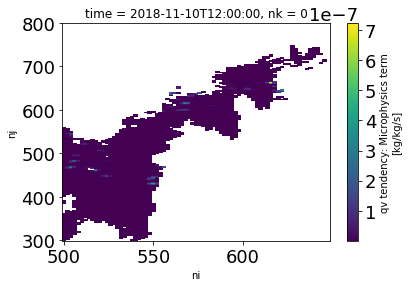

In [43]:
qvb_mp_west_xr[0,0,:,:].plot()

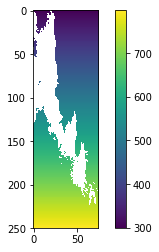

In [28]:
plt.imshow(ypos_east_xr.values[0,0,:,:])
plt.colorbar()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

def plot_trajectory(X1,X2,x_step,Y1,Y2,y_step,KK):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xpos_xr.sel(nk=KK,nj=slice(Y1,Y2,y_step),ni=slice(X1,X2,x_step)).values, ypos_xr.sel(nk=KK,nj=slice(Y1,Y2,y_step),ni=slice(X1,X2,x_step)).values,\
               zpos_xr.sel(nk=KK,nj=slice(Y1,Y2,y_step),ni=slice(X1,X2,x_step)).values, c='r', marker='o',s=1)

    #x = range(ni)
    #y = range(nj)
    #X, Y = np.meshgrid(x, y)

    #ax.plot_surface(X,Y,np.flip(zs), rstride=10, cstride=10,cmap='viridis', edgecolor='none')
    #ax.contour3D(X, Y, Z, 50, cmap='binary')
    #ax.plot_wireframe(X, Y, Z, color='black')
    #print(ds.xh.values[0,-1])
    #ax.set_xlim([0,xh[0:-1]])
    #ax.set_ylim([0,yh[0:-1]])
    #print(yh)
    #ax.set_xlim([0,zh[0,-1]])

    ax.set_xlabel('X distance (km)',fontsize=18)
    ax.set_ylabel('Y distance (km)',fontsize=18)
    ax.set_zlabel('height (m)',fontsize=18)

    plt.show()
    #ax.view_init(60, 90)
    #fig

plot_trajectory(530,595,4,450,500,10,0)

In [ ]:
xh

In [ ]:
print(np.shape(xpos_xr.sel(nk=0,nj=slice(450),ni=slice(550,)).values))

In [ ]:
print(np.shape(xpos))
ntimes     =np.shape(xpos)[0]
num_seeds_z=np.shape(xpos)[1]
num_seeds_y=np.shape(xpos)[2]
num_seeds_x=np.shape(xpos)[3]

In [ ]:
plt.imshow(xpos[30,0,:,:])
plt.colorbar()
print(xpos[0,0,:,:].max())

# Plot trajectory data

In [11]:
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection


###############################################################################
############################ Trajectory Plot  #################################
###############################################################################
############  Functions for coloring lines with third variable ################

xlmin = 0.002#-2.0*10**-6#290.0#
xlmax = 0.020#3500.0#2.1*10**-6#320.0#
xlevels = np.arange(xlmin,xlmax,0.001)# 0.0010
#Colormaps
cmap = cm.Spectral
cmapf = cm.Greys_r

#xlevels_ticks = np.arange(xlmin,xlmax,1)
#xlevels_ticks_labels = np.arange(xlmin,xlmax, 1).astype(int)


def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

# Interface to LineCollection:
def colorline(x, y, z=None,xlevels=np.arange(0.002,0.020,0.001), cmap = cm.Spectral_r,linestyle='-',\
              linewidth=2, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    norm=matplotlib.colors.BoundaryNorm(xlevels,cmap.N)
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))     
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z]) 
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha, zorder = 3)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc

def extract_CM1_time(data_xarray): #
    year=data_xarray.year
    mon=data_xarray.month
    day=data_xarray.day
    hour=data_xarray.hour
    minute=data_xarray.minute
    second=data_xarray.second
    aa = data_xarray.time
    #print(aa)
    tiempo = (pd.to_datetime({'year':[year],'month': [mon],'day':[day],'hour':[hour],'minute':[minute],\
                          'second':[second]}, utc=True)) + aa.values
    return tiempo.dt.strftime("%Y-%m-%d %H:%M:%S")[0]+' UTC', tiempo.dt.strftime("%Y-%m-%d_%H-%M-%S")[0]

S [545, 570, 400, 600]
model level: 1
grid spacing (km) in x-direction:1.0000001


/glade/work/isingh9/my_python/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'axis'
  s)


final_colorbar_RW_original_trajectories_ub_total_all_parcels_lev1_y400-600_S.png


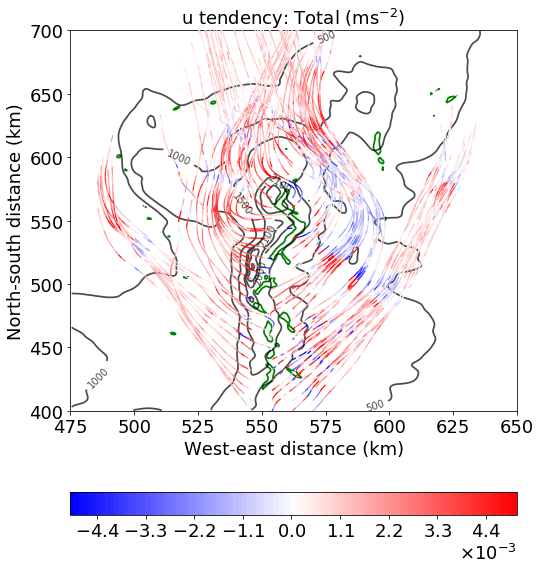

In [41]:
#%config InlineBackend.figure_format='retina'
plot_conv_line = True

def plot_conv_line(w_lev,w_thres,XPOS_XR,YPOS_XR,INPUT_VAR_XARRAY,VARNAME,x1,x2,x_sep,y1,y2,y_sep,ML,XLEVELS,CMAP,REGION):
    
    #ul_xind1=475 #upper left corner x
    #ul_yind1=700 #upper left corner y
    #br_xind1=650 #bottom right corner x
    #br_yind1=400 #bottom right corner y
    
    ul_xind1=475 #upper left corner x
    ul_yind1=700 #upper left corner y
    br_xind1=650 #bottom right corner x
    br_yind1=400 #bottom right corner y
    
    direc3 = "/glade/u/home/isingh9/scratch/cm119.8_run_RW_original/" #Radiation and winds and cold bubble 
    filename="cm1out_000067.nc"
    data = xr.open_dataset(direc3+filename)
    #print(data)
    ni   =      (data.dims['ni'])
    nj   =      (data.dims['nj'])
    nk   =      (data.dims['nk'])
    nip1 =      (data.dims['nip1'])
    njp1 =      (data.dims['njp1'])
    nkp1 =      (data.dims['nkp1'])
    timesteps = (data.dims['time'])
    xh = data.xh.values
    yh = data.yh.values
    z  = data.z.values
    zf = data.zf.values
    zh = data.zh.values
    zs = data.zs.values
    dx = data.xh.values[1] - data.xh.values[0]
    dy = data.yh.values[1] - data.yh.values[0]
    #print(zh)
    year=data.year
    mon=data.month
    day=data.day
    hour=data.hour
    minute=data.minute
    second=data.second

    panel_plot = False
    my_dpi = 200
    print('grid spacing (km) in x-direction:'+str(dx))
    XH, YH = np.meshgrid(xh[ul_xind1:br_xind1], yh[br_yind1:ul_yind1])
    XV, ZV = np.meshgrid(xh[ul_xind1:br_xind1], z)
    YVV, ZVV = np.meshgrid(yh[br_yind1:ul_yind1], z)
    #zs = zs[0,br_yind1:ul_yind1,ul_xind1:br_xind1]

    winds_thin_x=20
    winds_thin_z=5
    winds_thin_y=20
    XH, YH = np.meshgrid(xh[ul_xind1:br_xind1], yh[br_yind1:ul_yind1])
    XV, ZV = np.meshgrid(xh[ul_xind1:br_xind1], z)
    YVV, ZVV = np.meshgrid(yh[br_yind1:ul_yind1], z)
    
    plot_mass_conv=True
    if plot_mass_conv:
        u = data.variables['uinterp'][0,1,br_yind1:ul_yind1,ul_xind1:br_xind1]
        v = data.variables['vinterp'][0,1,br_yind1:ul_yind1,ul_xind1:br_xind1]
        mconv = (np.gradient(u,dx*1000.0,axis=1) + np.gradient(v,dy*1000.0,axis=0))*(-1.0)
        mconv_xr   = xr.DataArray(data=np.array(mconv),dims=['nj','ni'],attrs={'long_name':'mass convergence at model level 1',\
                                                               'units':'$s^{-1}$'})
        
    #from skimage.measure import label, regionprops
    #from skimage.transform import rotate
    #from skimage import filters
    #from skimage.segmentation import clear_border
    #from skimage.morphology import closing, square
    #import matplotlib.patches as mpatches
    #from skimage.morphology import flood
    ############# SEGMENTATION #######################################################################
    # apply threshold
    #var1=data.variables['winterp'][0,w_lev,br_yind1:ul_yind1,ul_xind1:br_xind1]
    #var1[:,:]
    #IMAGE=var1.values
    #bw = closing(IMAGE > w_thres, square(3))

    # remove artifacts connected to image border
    #cleared = clear_border(bw)

    # label image regions
    #label_image = label(cleared)

    #C6 = plt.contour(XH,YH,label_image,levels=[1],colors = 'darkblue',linewidths=1.1,linestyles='--', axis=AX)
    #regions = [rr for rr in regionprops(label_image)]
    #areas = [r.area for r in regions]
    #max_area_ind= areas.index(max(areas))
    #max_area=areas[max_area_ind]
    #max_area_label_coords_array = regions[max_area_ind].coords
    
    fig = plt.figure(figsize=(8,10),frameon=False)
    AX = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    
    #for region in regions:
    #    # take regions with large enough areas
    #    if region.area >= max_area:
    #        #print(region)
    #        print('Label: {} at {} >> Object size: {}'.format(region.label,region.centroid,region.area))
            
    
    #rows = [uu[0] for uu in max_area_label_coords_array]
    #cols = [uu[1] for uu in max_area_label_coords_array]
    #neu_arr=np.zeros_like(label_image)#*np.nan
    #neu_arr[max_area_label_coords]=1.0
    #neu_arr[rows,cols]=1.0

    #cin=data.variables['cin'][0,br_yind1:ul_yind1,ul_xind1:br_xind1]
    #levels_cin   = np.arange(0,50,1)
    #C_cin = plt.contourf(XH,YH,cin,levels=np.arange(0,101,1),cmap=plt.get_cmap('Greys'),axis=AX,extend='both')#,linewidths=1.75,linestyles='--', axis=AX)

    
    # plot trajectories
    for ii in np.arange(x1,x2,x_sep):  
        for jj in np.arange(y1,y2,y_sep): 
            #trajectories_xz = colorline(xpos[:,ML,jj,ii],ypos[:,ML,jj,ii],qv[:,ML,jj,ii],\
            #                            cmap=CMAP, alpha = 0.8, linewidth =0.6)
            trajectories_xz = colorline(XPOS_XR.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,YPOS_XR.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,\
                                        INPUT_VAR_XARRAY.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,\
                                        xlevels=XLEVELS,cmap=CMAP, alpha = 1.0, linewidth =1.2)
            #trajectories_xz1 = plt.plot(xpos_west_xr.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,ypos_west_xr.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,\
            #                            color='firebrick',linewidth=0.85)#,\
            #trajectories_xz2 = plt.plot(xpos_east_xr.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,ypos_east_xr.sel(nk=ML,nj=jj,ni=ii,method='nearest').values,
            #                            color='olivedrab',linewidth=0.85)#,\

    # mass_conv
    if plot_mass_conv:
        C_mass = plt.contour(XH,YH,mconv_xr,levels = [0.002],colors = "green",linewidths=1.75,linestyles='-',axis=AX)

        
    # plot convergence line      
    #C7 = plt.contour(XH,YH,neu_arr,levels=[1.0],colors='k',linewidths=2.1,\
    #                 linestyles='--', axis=AX)
    # plot terrain
    levels_zs_l   = np.array([500.,1000.,1500.,2000.,2100.,2200.,2300.])
    #levels_zs_f   = np.arange(0,2310,10)
    #C4_f = plt.contourf(XH,YH,data.zs[0,br_yind1:ul_yind1,ul_xind1:br_xind1],\
    #                 levels = levels_zs_f,cmap=plt.get_cmap('Greys_r'),linewidths=1.25, axis=AX) #linestyles='-'
    C4_l = plt.contour(XH,YH,data.zs[0,br_yind1:ul_yind1,ul_xind1:br_xind1],\
                     levels = levels_zs_l,colors='k',linewidths=1.75, axis=AX,alpha=0.7,linestyles='-')
    
    AX.clabel(C4_l, C4_l.levels,fmt='%.0f',inline=True,fontsize=10)
    # plot reflectivity
    dbz=data.variables['dbz'][0,0,br_yind1:ul_yind1,ul_xind1:br_xind1]
    levels_dbz   = np.array([35.])
    #C_dbz = plt.contour(XH,YH,dbz,\
    #                 levels = levels_dbz,colors = "blue",linewidths=1.75,linestyles='-', axis=AX)
     

    #AX.add_patch(mpl.patches.Rectangle((x1,y1),x2-x1,y2-y1,fill=None, lw=1.5, edgecolor='k', zorder=10))
    

    #AX.add_patch(mpl.patches.Rectangle((535,410),15,40,fill=None, lw=1.0,ls='--',edgecolor='k', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((540,480),12,50,fill=None, lw=1.0,ls='--',edgecolor='k', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((560,470),15,50,fill=None, lw=1.0,ls='--',edgecolor='k', zorder=10))
    #AX.add_patch(mpl.patches.Rectangle((560,410),15,40,fill=None, lw=1.0,ls='--',edgecolor='k', zorder=10))
    
    #plt.colorbar(trajectories_xz)
    fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = plt.colorbar(trajectories_xz,format=fmt,orientation='horizontal')
    #cbar=plt.colorbar(trajectories_xz,orientation='horizontal')
    #cbar.ax.set_ylabel('water vapor mixing ratio (kg/kg)',fontsize=17.0)
    
    #cbar1=plt.colorbar(C_cin,orientation="horizontal")
    #cbar1.ax.set_ylabel('SBCIN (J/kg)',fontsize=17.0)
    
    plt.xlim([ul_xind1,br_xind1])
    plt.ylim([br_yind1,ul_yind1])   
    #plt.axes().set_aspect(.6)
    plt.xlabel('West-east distance (km)',fontsize=18)
    plt.ylabel('North-south distance (km)',fontsize=18)
    plt.title(INPUT_VAR_XARRAY.long_name + ' ($ms^{-2}$)')
    #plt.title('Backward trajectories from '+'model level '+str(ML)+' (150 m AGL)'\
    #          '\n beginning at '+extract_CM1_time(data)[0],fontsize=18)
    matplotlib.rc('xtick', labelsize=18) 
    matplotlib.rc('ytick', labelsize=18) 
    plt.draw()
    #plt.show()
 
    pngname='final_colorbar_RW_original_trajectories_'+VARNAME+'_all_parcels_lev'+str(ML)+'_y'+str(y1)+'-'+str(y2)+'_'\
    +REGION+'.png'
    print(pngname)
    plt.savefig(pngname,dpi=300.)
    #plt.close()

#regiones={'N':[20,35,70,150]}#,'S':[20,35,30,70]}
#regiones={'N':[20,35,70,150]}#,'S':[20,35,30,70]}
#regiones={'S':[547,570,470,540]}
#for yyy in np.arange(530,540,10):
#regiones={'S':[560,575,410,450]}
regiones={'S':[545,570,400,600]} # original
model_levels=[1]#,2,5,7,8,10,12,15,20]
for key,value in regiones.items():
    print(key,value)
    for item in model_levels:
        print('model level:',item)
        #             (w_lev,w_thres,INPUT_VAR_XARRAY,VARNAME,x1,x2,x_sep,y1,y2,y_sep,ML,XLEVELS,CMAP,REGION)
        plot_conv_line(10,0.7,xpos_xr,ypos_xr,ub_total_xr,'ub_total',value[0],value[1],8,value[2],value[3],8,item,np.arange(-0.005,0.0051,.0001),cma1,key)
#plot_conv_line(w_lev,w_thres,VARNAME,ML)

In [ ]:
#### from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import matplotlib.dates as mdates
time_steps=60
times = qv_xr.time.values[0:-1][::-1]
print(len(times))
def plot_traj_var(k1,y1,y2,x1,x2,region,plotting):
        
    
    def calc_median_max_min_std(VAR_XARRAY,K1,Y1,Y2,X1,X2,FACTOR):
        median_v = np.nanmedian(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        max_v    = np.nanmax(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        min_v    = np.nanmin(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        std_v    = np.nanstd(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        
        return median_v,max_v,min_v,std_v
        
    qv_median_west,qv_max_west,qv_min_west,qv_std_west = calc_median_max_min_std(qv_west_xr,k1,y1,y2,x1,x2,1000.0)
    qv_median_east,qv_max_east,qv_min_east,qv_std_east = calc_median_max_min_std(qv_east_xr,k1,y1,y2,x1,x2,1000.0)

    zpos_median_west,zpos_max_west,zpos_min_west,zpos_std_west = calc_median_max_min_std(zpos_west_xr,k1,y1,y2,x1,x2,1.0)
    zpos_median_east,zpos_max_east,zpos_min_east,zpos_std_east = calc_median_max_min_std(zpos_east_xr,k1,y1,y2,x1,x2,1.0)
    
    fig= plt.figure(figsize=(12,7))
    host = fig.add_subplot(111)
    plt.subplots_adjust(right=0.60)

    par1 = host.twinx()
    
    host.set_ylim(0,5000)
    host.set_xlabel("Time (UTC)",fontsize=18)
    host.set_ylabel("Height (m)",color='black',fontsize=18)
    
    par1.set_ylim(0,20)
    par1.set_ylabel("qv (g/kg)",color='green',fontsize=18)
    
    #-----------------------------------------------------------------
    p1w, = host.plot(times,zpos_median_west,color='k',linewidth=2.5,linestyle='--')
    p11w  = host.fill_between(times,zpos_median_west+zpos_std_west,zpos_median_west-zpos_std_west,facecolor='black',alpha=0.15)
    
    p1e, = host.plot(times,zpos_median_east,color='k',linewidth=2.5,linestyle=':')
    p11e  = host.fill_between(times,zpos_median_east+zpos_std_east,zpos_median_east-zpos_std_east,facecolor='black',alpha=0.15)

    p2w, = par1.plot(times,qv_median_west,color='g',linewidth=2.5,linestyle='--')
    p22w  = par1.fill_between(times,qv_median_west+qv_std_west,qv_median_west-qv_std_west,facecolor='green',alpha=0.15)
    
    p2e, = par1.plot(times,qv_median_east,color='g',linewidth=2.5,linestyle=':')
    p22e  = par1.fill_between(times,qv_median_east+qv_std_east,qv_median_east-qv_std_east,facecolor='green',alpha=0.15)
    #-----------------------------------------------------------------

    # Define the date format
    date_form = mdates.DateFormatter("%H:%M")
    host.xaxis.set_major_formatter(date_form)
    # Ensure a major tick for each week using (interval=1) 
    host.xaxis.set_major_locator(mdates.HourLocator(interval=1))

    #plt.title(region+' model level '+str(k1),fontsize=18)

    lines = [p1w,p1e,p2w,p2e]#, p4, p5]
    filename='traj_th_k'+str(k1)+'_y'+str(y1)+'_x'+str(x1)+'_'+region+'.png'
    print(filename)
    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='k', lw=3,ls='--'),
                Line2D([0], [0], color='k', lw=3,ls=':')]


    host.legend(custom_lines, ['westerly branch', 'easterly branch'],fontsize=17)
    
    if plotting:
        plt.savefig(filename,dpi=300.)
        plt.draw()
        plt.show()

#plot_traj_var(k1,y1,y2,x1,x2,region):
plot_traj_var(1,470,540,545,575,'CI',True)

60
east
potential temperature
west
potential temperature
traj_th_k1_y470_x547_CI.png


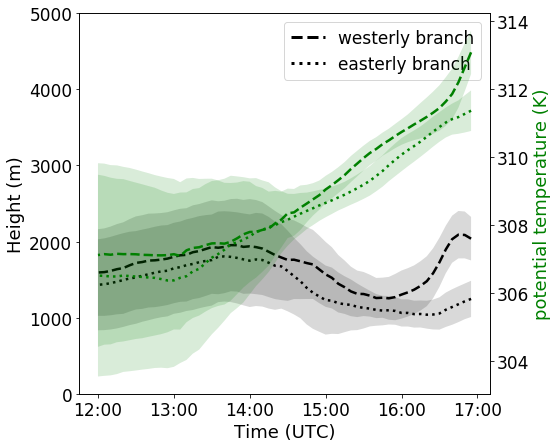

In [61]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
time_steps=60
times = qv_xr.time.values[0:-1][::-1]
print(len(times))

def plot_traj_var(VAR_EAST_ARRAY,VAR_WEST_ARRAY,k1,y1,y2,x1,x2,region,plotting):
        
    print(VAR_EAST_ARRAY.branch)
    print(VAR_EAST_ARRAY.long_name)
    print(VAR_WEST_ARRAY.branch)
    print(VAR_WEST_ARRAY.long_name)
    
    def calc_median_max_min_std(VAR_XARRAY,K1,Y1,Y2,X1,X2,FACTOR):
        median_v = np.nanmedian(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        max_v    = np.nanmax(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        min_v    = np.nanmin(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        std_v    = np.nanstd(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        
        return median_v,max_v,min_v,std_v
        
    qv_median_west,qv_max_west,qv_min_west,qv_std_west = calc_median_max_min_std(VAR_WEST_ARRAY,k1,y1,y2,x1,x2,1.0)
    qv_median_east,qv_max_east,qv_min_east,qv_std_east = calc_median_max_min_std(VAR_EAST_ARRAY,k1,y1,y2,x1,x2,1.0)

    zpos_median_west,zpos_max_west,zpos_min_west,zpos_std_west = calc_median_max_min_std(zpos_west_xr,k1,y1,y2,x1,x2,1.0)
    zpos_median_east,zpos_max_east,zpos_min_east,zpos_std_east = calc_median_max_min_std(zpos_east_xr,k1,y1,y2,x1,x2,1.0)
    
    fig= plt.figure(figsize=(12,7))
    host = fig.add_subplot(111)
    plt.subplots_adjust(right=0.60)

    par1 = host.twinx()
    
    host.set_ylim(0,5000)
    host.set_xlabel("Time (UTC)",fontsize=18)
    plt.setp(host.get_yticklabels(), fontsize=17)
    plt.setp(host.get_xticklabels(), fontsize=17)
    host.set_ylabel("Height (m)",color='black',fontsize=18)
    
    #par1.plot([])
    #par1.set_ylim(0,20)
    par1.set_ylabel(VAR_EAST_ARRAY.long_name+' ('+VAR_EAST_ARRAY.units+')',color='green',fontsize=18)
    plt.setp(par1.get_yticklabels(), fontsize=17)

    #par1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.1e'))
    
    #-----------------------------------------------------------------
    p1w, = host.plot(times,zpos_median_west,color='k',linewidth=2.5,linestyle='--')
    p11w  = host.fill_between(times,zpos_median_west+zpos_std_west,zpos_median_west-zpos_std_west,facecolor='black',alpha=0.15)
    
    p1e, = host.plot(times,zpos_median_east,color='k',linewidth=2.5,linestyle=':')
    p11e  = host.fill_between(times,zpos_median_east+zpos_std_east,zpos_median_east-zpos_std_east,facecolor='black',alpha=0.15)

    p2w, = par1.plot(times,qv_median_west,color='g',linewidth=2.5,linestyle='--')
    p22w  = par1.fill_between(times,qv_median_west+qv_std_west,qv_median_west-qv_std_west,facecolor='green',alpha=0.15)
    
    p2e, = par1.plot(times,qv_median_east,color='g',linewidth=2.5,linestyle=':')
    p22e  = par1.fill_between(times,qv_median_east+qv_std_east,qv_median_east-qv_std_east,facecolor='green',alpha=0.15)
    #-----------------------------------------------------------------

    # Define the date format
    date_form = mdates.DateFormatter("%H:%M")
    host.xaxis.set_major_formatter(date_form)
    # Ensure a major tick for each week using (interval=1) 
    host.xaxis.set_major_locator(mdates.HourLocator(interval=1))

    #plt.title(region+' model level '+str(k1),fontsize=18)

    lines = [p1w,p1e,p2w,p2e]#, p4, p5]
    
    filename='traj_'+VAR_EAST_ARRAY.short_name+'_k'+str(k1)+'_y'+str(y1)+'_x'+str(x1)+'_'+region+'.png'
    print(filename)
    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='k', lw=3,ls='--'),
                Line2D([0], [0], color='k', lw=3,ls=':')]


    host.legend(custom_lines, ['westerly branch', 'easterly branch'],fontsize=17)
    
    if plotting:
        plt.savefig(filename,dpi=300.)
        #plt.draw()
        #plt.show()
        #plt.close()

east_arrays=[qvb_mp_east_xr,qvb_pbl_east_xr,qvb_total_east_xr,ub_pbl_east_xr,ub_pgrad_east_xr,ub_cor_east_xr,ub_total_east_xr,\
            vb_pbl_east_xr,vb_pgrad_east_xr,vb_cor_east_xr,vb_total_east_xr,wb_pgrad_east_xr,wb_buoy_east_xr,wb_total_east_xr,\
            qv_east_xr,th_east_xr,thetae_east_xr,prs_east_xr,\
            ptb_div_east_xr,ptb_mp_east_xr,ptb_rad_east_xr,ptb_pbl_east_xr,ptb_total_east_xr,\
            xvort_east_xr,yvort_east_xr,zvort_east_xr]


west_arrays=[qvb_mp_west_xr,qvb_pbl_west_xr,qvb_total_west_xr,ub_pbl_west_xr,ub_pgrad_west_xr,ub_cor_west_xr,ub_total_west_xr,\
            vb_pbl_west_xr,vb_pgrad_west_xr,vb_cor_west_xr,vb_total_west_xr,wb_pgrad_west_xr,wb_buoy_west_xr,wb_total_west_xr,\
            qv_west_xr,th_west_xr,thetae_west_xr,prs_west_xr,\
            ptb_div_west_xr,ptb_mp_west_xr,ptb_rad_west_xr,ptb_pbl_west_xr,ptb_total_west_xr,\
            xvort_west_xr,yvort_west_xr,zvort_west_xr]

#for ii in range(len(east_arrays)):
#    #plot_traj_var(k1,y1,y2,x1,x2,region):
plot_traj_var(east_arrays[15],west_arrays[15],1,470,540,547,570,'CI',True)

60
nii =  8
njj =  21
traj_ub_total_k1_y410-450_x560-575_CI_revisions1.png


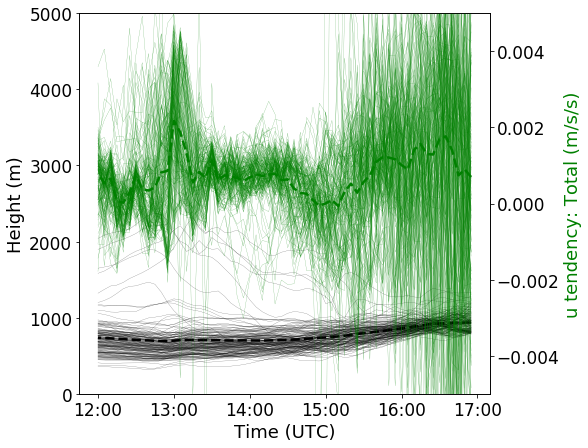

In [43]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
time_steps=60
times = qv_xr.time.values[0:-1][::-1]
print(len(times))

def plot_traj_var(VAR_ARRAY,k1,y1,y2,x1,x2,region,plotting):
        
    
    def calc_median_max_min_std(VAR_XARRAY,K1,Y1,Y2,X1,X2,FACTOR):
        median_v = np.nanmean(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        #print(np.shape(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values))
        max_v    = np.nanmax(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        min_v    = np.nanmin(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        std_v    = np.nanstd(VAR_XARRAY[0:-1,:,:,:].sel(nk=K1,nj=slice(Y1,Y2),ni=slice(X1,X2)).values*FACTOR,axis=(1,2))
        
        return median_v,max_v,min_v,std_v
        
    qv_median,qv_max,qv_min,qv_std = calc_median_max_min_std(VAR_ARRAY,k1,y1,y2,x1,x2,1.0)

    zpos_median,zpos_max,zpos_min,zpos_std = calc_median_max_min_std(zpos_xr,k1,y1,y2,x1,x2,1.0)
    
    fig= plt.figure(figsize=(12,7))
    host = fig.add_subplot(111)
    plt.subplots_adjust(right=0.60)

    par1 = host.twinx()
    
    host.set_ylim(0,5000)
    host.set_xlabel("Time (UTC)",fontsize=18)
    plt.setp(host.get_yticklabels(), fontsize=17)
    plt.setp(host.get_xticklabels(), fontsize=17)
    host.set_ylabel("Height (m)",color='black',fontsize=18)
    
    #par1.plot([])
    #par1.set_ylim(0,20)
    par1.set_ylabel(VAR_ARRAY.long_name+' ('+VAR_ARRAY.units+')',color='green',fontsize=18)
    plt.setp(par1.get_yticklabels(), fontsize=17)

    #par1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%2.1e'))
    
    #-----------------------------------------------------------------
    nii = np.shape(VAR_ARRAY[0:-1,:,:,:].sel(nk=k1,nj=slice(y1,y2),ni=slice(x1,x2)).values)[2]
    njj = np.shape(VAR_ARRAY[0:-1,:,:,:].sel(nk=k1,nj=slice(y1,y2),ni=slice(x1,x2)).values)[1]
    varr=VAR_ARRAY[0:-1,:,:,:].sel(nk=k1,nj=slice(y1,y2),ni=slice(x1,x2)).values
    zposr=zpos_xr[0:-1,:,:,:].sel(nk=k1,nj=slice(y1,y2),ni=slice(x1,x2)).values
    
    print('nii = ',nii)
    print('njj = ',njj)
    
    counter=0               
    for ii in np.arange(0,nii,1):
        for jj in np.arange(0,njj,1):
            #print('counter = ',counter)
            par1.plot(times,varr[:,jj,ii],color='green',linewidth=0.2,linestyle='-',alpha=0.7)
            #counter=counter+1
            
    counter=0
    for ii in np.arange(0,nii,1):
        for jj in np.arange(0,njj,1):
            #print('counter = ',counter)
            host.plot(times,zposr[:,jj,ii],color='k',linewidth=0.2,linestyle='-',alpha=0.7)
            #counter=counter+1
            
    p1w, = host.plot(times,zpos_median,color='k',linewidth=2.5,linestyle='--')
    #p11w  = host.fill_between(times,zpos_median+zpos_std,zpos_median-zpos_std,facecolor='black',alpha=0.15)
    
    p2w, = par1.plot(times,qv_median,color='g',linewidth=2.5,linestyle='--')
    #p22w  = par1.fill_between(times,qv_median+qv_std,qv_median-qv_std,facecolor='green',alpha=0.15)
    #-----------------------------------------------------------------

    
    #host.set_ylim([0,3500.])
    par1.set_ylim([-0.005,0.005])
    # Define the date format
    date_form = mdates.DateFormatter("%H:%M")
    host.xaxis.set_major_formatter(date_form)
    # Ensure a major tick for each week using (interval=1) 
    host.xaxis.set_major_locator(mdates.HourLocator(interval=1))

    #plt.title(region+' model level '+str(k1),fontsize=18)

    #lines = [p1w,p2w]#, p4, p5]
    
    filename='traj_'+VAR_ARRAY.short_name+'_k'+str(k1)+'_y'+str(y1)+'-'+str(y2)+'_x'+str(x1)+'-'+str(x2)+'_'+region+'_revisions1.png'
    print(filename)
    
    #from matplotlib.lines import Line2D
    #custom_lines = [Line2D([0], [0], color='k', lw=3,ls='--'),
    #            Line2D([0], [0], color='k', lw=3,ls=':')]


    #host.legend(custom_lines, ['western branch', 'eastern branch'],fontsize=17)
    
    if plotting:
        plt.savefig(filename,dpi=300.)
        #plt.draw()
        #plt.show()
        #plt.close()

arrays=[qvb_mp_xr,qvb_pbl_xr,qvb_total_xr,ub_pbl_xr,ub_pgrad_xr,ub_cor_xr,ub_total_xr,\
            vb_pbl_xr,vb_pgrad_xr,vb_cor_xr,vb_total_xr,wb_pgrad_xr,wb_buoy_xr,wb_total_xr,\
            qv_xr,th_xr,thetae_xr,prs_xr,\
            ptb_div_xr,ptb_mp_xr,ptb_rad_xr,ptb_pbl_xr,ptb_total_xr,\
            xvort_xr,yvort_xr,zvort_xr]

#for ii in range(len(east_arrays)):
#    #plot_traj_var(k1,y1,y2,x1,x2,region):
plot_traj_var(ub_total_xr,1,410,450,560,575,'CI',True)
# original 470,540,547,570
#

In [ ]:
print(type(qv_xr.time.values[0]))

In [ ]:
print(np.shape(zpos_median_sigma1))
print(np.shape(times))

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.60)

par1 = host.twinx()
par2 = host.twinx()
#par3 = host.twinx()
#par4 = host.twinx()
#-----------------------------------------------------------------
offset = 30
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
#offset = 65
#new_fixed_axis = par3.get_grid_helper().new_fixed_axis
#par3.axis["right"] = new_fixed_axis(loc="right", axes=par3,
#                                        offset=(offset, 0))

#par3.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
#offset = 115
#new_fixed_axis = par4.get_grid_helper().new_fixed_axis
#par4.axis["right"] = new_fixed_axis(loc="right", axes=par4,
#                                        offset=(offset, 0))

#par4.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
host.set_xlim(0, 79)
host.set_ylim(0,5000)

host.set_xlabel("Time step [ every 1 min ]",fontsize=14)
host.set_ylabel("Height (m)",color='black',fontsize=14)
par1.set_ylabel("theta (K)",color='green',fontsize=14)
par2.set_ylabel("qv (g/kg)",color='magenta',fontsize=14)
#par3.set_ylabel("Relative Humidity [ % ]",color='blue',fontsize=14)
#par4.set_ylabel("Theta-e [ K ]",color='red',fontsize=14)
#-----------------------------------------------------------------
p1, = host.plot(times,zpos_median_sigma1,color='k',linewidth=2.5)
p1  = host.fill_between(times,zpos_max_sigma1,zpos_min_sigma1,facecolor='black',alpha=0.15)

p2, = par1.plot(times,th_median_sigma1,color='g',linewidth=2.5)
p2  = par1.fill_between(times,th_max_sigma1,th_min_sigma1,facecolor='green',alpha=0.15)

p3, = par2.plot(times,qv_median_sigma1,color='m',linewidth=2.5)
p3  = par2.fill_between(times,qv_max_sigma1,qv_min_sigma1,facecolor='magenta',alpha=0.15)

#p4, = par3.plot(times,RH_median_sigma1,color='b',linewidth=2.5)
#p4  = par3.fill_between(times,RH_max_sigma1,RH_min_sigma1,facecolor='blue',alpha=0.15)

#p5, = par4.plot(times,ThetaE_median_sigma1,color='r',linewidth=2.5)
#p5  = par4.fill_between(times,ThetaE_max_sigma1,ThetaE_min_sigma1,facecolor='red',alpha=0.15)
#-----------------------------------------------------------------

par1.set_ylim(290,340)
par2.set_ylim(0,20)
#par3.set_ylim(0,100)
#par4.set_ylim(324,340)

plt.title('model level#1',fontsize=14)

lines = [p1, p2, p3]#, p4, p5]

#plt.savefig('/data/meso/a/jmulhol2/trajectory_figs/Qrain_and_Qgraupel_sigma1_BOTTOM_HIGH25.png',dpi=300.)

plt.draw()
plt.show()

In [ ]:
hor_resolution = (ds.xf[1].values-ds.xf[0].values)*1000
#Get surface height grid (set to zero if no terrain)
try:
    zs = np.array(ds.zs[0,:,:])
except:
    zs = np.zeros((ds.ny, ds.nx))  

In [ ]:
print(shape(zpos))

In [ ]:
#Plot Dimensions
top = 60
left = 0

ymid = np.int(ds.ny/2)
x1d = ds.xh[0,left:].values
y1d = ds.yh[0,:].values
#print(x1d)

x2d = np.rot90(np.repeat(x1d,top, axis = 0).reshape(ds.nx-left,top))
y2d = np.rot90(np.repeat(y1d,top, axis = 0).reshape(ds.ny-left,top))
z2dxz = np.repeat(ds.z[0,:top].values*1000,ds.nx-left, axis = 0).reshape(top, ds.nx-left)
z2dyz = np.repeat(ds.z[0,:top].values*1000,ds.ny-left, axis = 0).reshape(top, ds.ny-left)
#y2d_500 = dsj500.zh[0,:top,ymid,left:].values*z_scale
#y2d_2000 = dsj2000.zh[0,:top,ymid,left:].values*z_scale

#Model output
time = 40

qcxy = ds.qc[time,:top,:,:]
qrxy = ds.qr[time,:top,:,:]
qixy = ds.qi[time,:top,:,:]
qgxy = ds.qg[time,:top,:,:]
qsxy = ds.qs[time,:top,:,:]
#Total
qxy  = (qcxy + qrxy + qixy + qgxy + qsxy).max(dim = ('nk')).values*1000
#qxy  = ds.th[time,2,:,:].values

qcxz = ds.qc[time,:top,:,:]
qrxz = ds.qr[time,:top,:,:]
qixz = ds.qi[time,:top,:,:]
qgxz = ds.qg[time,:top,:,:]
qsxz = ds.qs[time,:top,:,:]
#Total
qxz  = (qcxz + qrxz + qixz + qgxz + qsxz).max(dim = ('nj')).values*1000
#qxz  = ds.th[time,:top,ymid,:].values


qcyz = ds.qc[time,:top,:,:]
qryz = ds.qr[time,:top,:,:]
qiyz = ds.qi[time,:top,:,:]
qgyz = ds.qg[time,:top,:,:]
qsyz = ds.qs[time,:top,:,:]
#Total
qyz  = (qcyz + qryz + qiyz + qgyz + qsyz).max(dim = ('ni')).values*1000
#qyz  = ds.th[time,:top,:,2800].values


In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(15,9.5), facecolor='w', edgecolor='k')
#plt.subplots_adjust(left=0.05, bottom=0.1, right=0.985, top=0.98, wspace=0.655, hspace=0.555)

#Color range of Varible1 (set by user)
xlmin = 266
xlmax = 320.01
xlevels = np.arange(xlmin,xlmax, 0.1)
xlevels_ticks = np.arange(xlmin,xlmax,1)
xlevels_ticks_labels = np.arange(xlmin,xlmax, 1).astype(int)

#Levels for qc
lmin = 0.1
lmax = 2.601
levels = (np.arange(lmin,lmax, 0.01))
levels_ticks = np.arange(lmin,lmax,0.5)
levels_ticks_labels = np.round(levels_ticks, 1)

#Levels for th
# lmin = 265
# lmax = 270
# levels = (np.arange(lmin,lmax, 1))
# levels_ticks = levels
# levels_ticks_labels = np.round(levels_ticks, 1)

#Colormaps
cmap = cm.Spectral_r
cmapf = cm.Greys_r

#Dimensions
left = 1500

###################  Plot Trajectories in y-z plane ###############################

#Create subplot
ax = plt.subplot(111)
#To make same lengtho as x-z plot
scale = 3.6

plot = plt.contourf(np.rot90(z2dyz,3)-50, np.rot90((y2d-y2d[0,0])*1000/125,3), np.rot90(qyz,3), levels, cmap = cmapf, extend = 'max', alpha = 1,  zorder = 3, vmin = -0.8)

#Plots trjectory with lowest mean x first, then scond, then third...
xpos_seg = np.nanmean(xpos[:,:,:], axis = 0)
xord = np.argsort(xpos_seg[:,:])
for i in range(len(xpos[0,:,0])):
    for j in range(len(xpos[0,0,:])):
        ind  = xord[-i, -j]
        trajectories_xz = colorline(zpos[:,i,ind], ypos[:,i,ind], variable1[:,i,ind], cmap, alpha = 0.8, linewidth = 2.5)

#Ticks and labels (set by user)
yticks = np.arange(0,ds.ny+1,200)
xticks = np.arange(0,4001,1000)
plt.yticks(yticks)
plt.xticks(xticks)
ytickslabs = (yticks*1000/1000).astype(int) #kilometers
xtickslabs = (xticks/1000).astype(int) #km
ax.set_yticklabels((ytickslabs), fontsize = 12)
ax.set_xticklabels((xtickslabs), fontsize = 12)
plt.xlabel('Height (km)', fontsize = 16)

#Limits and characteristics (set by user)
plt.ylim(0,ds.ny)
plt.xlim(-50,4000)
plt.axvspan(0,4000,color='gainsboro',lw=0)
plt.grid(True, color = 'white')


#Plot Lake (set by user)
#y1d = np.arange(0,ds.ny,1)
#lake = np.array(ds.xland[0,:,2000])
#lake[lake == 1] = np.nan
#lake_plt = plt.plot(lake-15, y1d, c = 'blue', linewidth = 4, zorder = 5)

#Plot Terrain (set by user)
#y1d = np.arange(0,ds.ny,1)
#terrain = plt.plot(zs[:,2000]-15, y1d, c = 'slategrey', linewidth = 4, zorder = 4)


#Colorbar
cbaxes = fig.add_axes([0.84, 0.74, 0.025, 0.23])
cbar = plt.colorbar(trajectories_xz, orientation='vertical', cax = cbaxes, ticks = xlevels_ticks)
cbar.ax.set_yticklabels(xlevels_ticks_labels)
cbar.ax.tick_params(labelsize=12)
plt.text(0.82,-0.13, 'Theta (K)', fontsize = 14, ha='center', va='center')

#Colorbar
cbaxes = fig.add_axes([0.92, 0.74, 0.025, 0.23])
cbar = plt.colorbar(plot_q, orientation='vertical', cax = cbaxes, ticks = levels_ticks)
cbar.ax.set_yticklabels(levels_ticks_labels)
cbar.ax.tick_params(labelsize=12)
#plt.text(0.82,-0.13, '$g$ $kg^-$$^1$', fontsize = 14, ha='center', va='center')

In [ ]:
times = np.arange(0,30,1)

xpos_HIGH25     = np.load('xpos.npy')
ypos_HIGH25     = np.load('ypos.npy')
zpos_HIGH25     = np.load('zpos.npy')
RH_HIGH25       = np.load('RH.npy')
ThetaE_HIGH25   = np.load('Theta_e.npy')
Qrain_HIGH25    = np.load('Qrain.npy')
Qgraupel_HIGH25 = np.load('Qgraupel.npy')

### sigma = 1 (BOTTOM) ###

RH_median_sigma1 = np.median(RH_HIGH25[:,1,:],axis=1)
RH_max_sigma1    = np.nanmax(RH_HIGH25[:,1,:],axis=1)
RH_min_sigma1    = np.nanmin(RH_HIGH25[:,1,:],axis=1)

ThetaE_median_sigma1 = np.median(ThetaE_HIGH25[:,1,:],axis=1)
ThetaE_max_sigma1    = np.nanmax(ThetaE_HIGH25[:,1,:],axis=1)
ThetaE_min_sigma1    = np.nanmin(ThetaE_HIGH25[:,1,:],axis=1)

zpos_median_sigma1 = np.median(zpos_HIGH25[:,1,:],axis=1)
zpos_max_sigma1    = np.nanmax(zpos_HIGH25[:,1,:],axis=1)
zpos_min_sigma1    = np.nanmin(zpos_HIGH25[:,1,:],axis=1)

Qrain_median_sigma1 = np.median(Qrain_HIGH25[:,1,:]*1e3,axis=1)
Qrain_max_sigma1    = np.nanmax(Qrain_HIGH25[:,1,:]*1e3,axis=1)
Qrain_min_sigma1    = np.nanmin(Qrain_HIGH25[:,1,:]*1e3,axis=1)

Qgraupel_median_sigma1 = np.median(Qgraupel_HIGH25[:,1,:]*1e3,axis=1)
Qgraupel_max_sigma1    = np.nanmax(Qgraupel_HIGH25[:,1,:]*1e3,axis=1)
Qgraupel_min_sigma1    = np.nanmin(Qgraupel_HIGH25[:,1,:]*1e3,axis=1)

### sigma = 10 (MIDDLE) ###

RH_median_sigma10 = np.median(RH_HIGH25[:,10,:],axis=1)
RH_max_sigma10    = np.nanmax(RH_HIGH25[:,10,:],axis=1)
RH_min_sigma10    = np.nanmin(RH_HIGH25[:,10,:],axis=1)

ThetaE_median_sigma10 = np.median(ThetaE_HIGH25[:,10,:],axis=1)
ThetaE_max_sigma10    = np.nanmax(ThetaE_HIGH25[:,10,:],axis=1)
ThetaE_min_sigma10    = np.nanmin(ThetaE_HIGH25[:,10,:],axis=1)

zpos_median_sigma10 = np.median(zpos_HIGH25[:,10,:],axis=1)
zpos_max_sigma10    = np.nanmax(zpos_HIGH25[:,10,:],axis=1)
zpos_min_sigma10    = np.nanmin(zpos_HIGH25[:,10,:],axis=1)

### sigma = 20 (TOP) ###

RH_median_sigma20 = np.median(RH_HIGH25[:,20,:],axis=1)
RH_max_sigma20    = np.nanmax(RH_HIGH25[:,20,:],axis=1)
RH_min_sigma20    = np.nanmin(RH_HIGH25[:,20,:],axis=1)

ThetaE_median_sigma20 = np.median(ThetaE_HIGH25[:,20,:],axis=1)
ThetaE_max_sigma20    = np.nanmax(ThetaE_HIGH25[:,20,:],axis=1)
ThetaE_min_sigma20    = np.nanmin(ThetaE_HIGH25[:,20,:],axis=1)

zpos_median_sigma20 = np.median(zpos_HIGH25[:,20,:],axis=1)
zpos_max_sigma20    = np.nanmax(zpos_HIGH25[:,20,:],axis=1)
zpos_min_sigma20    = np.nanmin(zpos_HIGH25[:,20,:],axis=1)

Qrain_median_sigma20 = np.median(Qrain_HIGH25[:,20,:]*1e3,axis=1)
Qrain_max_sigma20    = np.nanmax(Qrain_HIGH25[:,20,:]*1e3,axis=1)
Qrain_min_sigma20    = np.nanmin(Qrain_HIGH25[:,20,:]*1e3,axis=1)

Qgraupel_median_sigma20 = np.median(Qgraupel_HIGH25[:,20,:]*1e3,axis=1)
Qgraupel_max_sigma20    = np.nanmax(Qgraupel_HIGH25[:,20,:]*1e3,axis=1)
Qgraupel_min_sigma20   = np.nanmin(Qgraupel_HIGH25[:,20,:]*1e3,axis=1)

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.60)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par4 = host.twinx()
#-----------------------------------------------------------------
offset = 30
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
offset = 65
new_fixed_axis = par3.get_grid_helper().new_fixed_axis
par3.axis["right"] = new_fixed_axis(loc="right", axes=par3,
                                        offset=(offset, 0))

par3.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
offset = 115
new_fixed_axis = par4.get_grid_helper().new_fixed_axis
par4.axis["right"] = new_fixed_axis(loc="right", axes=par4,
                                        offset=(offset, 0))

par4.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
host.set_xlim(0, 29)
host.set_ylim(0,5000)

host.set_xlabel("Time step [ every 1 min ]",fontsize=14)
host.set_ylabel("Height [ m ]",color='black',fontsize=14)
par1.set_ylabel("Qrain [ g / kg ]",color='green',fontsize=14)
par2.set_ylabel("Qgraupel [ g / kg ]",color='magenta',fontsize=14)
par3.set_ylabel("Relative Humidity [ % ]",color='blue',fontsize=14)
par4.set_ylabel("Theta-e [ K ]",color='red',fontsize=14)
#-----------------------------------------------------------------
p1, = host.plot(times,zpos_median_sigma1,color='k',linewidth=2.5)
p1  = host.fill_between(times,zpos_max_sigma1,zpos_min_sigma1,facecolor='black',alpha=0.15)

p2, = par1.plot(times,Qrain_median_sigma1,color='g',linewidth=2.5)
p2  = par1.fill_between(times,Qrain_max_sigma1,Qrain_min_sigma1,facecolor='green',alpha=0.15)

p3, = par2.plot(times,Qgraupel_median_sigma1,color='m',linewidth=2.5)
p3  = par2.fill_between(times,Qgraupel_max_sigma1,Qgraupel_min_sigma1,facecolor='magenta',alpha=0.15)

p4, = par3.plot(times,RH_median_sigma1,color='b',linewidth=2.5)
p4  = par3.fill_between(times,RH_max_sigma1,RH_min_sigma1,facecolor='blue',alpha=0.15)

p5, = par4.plot(times,ThetaE_median_sigma1,color='r',linewidth=2.5)
p5  = par4.fill_between(times,ThetaE_max_sigma1,ThetaE_min_sigma1,facecolor='red',alpha=0.15)

#-----------------------------------------------------------------
par1.set_ylim(0,5)
par2.set_ylim(0,5)
par3.set_ylim(0,100)
par4.set_ylim(324,340)

plt.title('HIGH-25 - Sigma = 1 (Bottom)',fontsize=14)

lines = [p1, p2, p3, p4, p5]

plt.savefig('/data/meso/a/jmulhol2/trajectory_figs/Qrain_and_Qgraupel_sigma1_BOTTOM_HIGH25.png',dpi=300.)

plt.draw()
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.60)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par4 = host.twinx()
#-----------------------------------------------------------------
offset = 30
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
offset = 65
new_fixed_axis = par3.get_grid_helper().new_fixed_axis
par3.axis["right"] = new_fixed_axis(loc="right", axes=par3,
                                        offset=(offset, 0))

par3.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
offset = 115
new_fixed_axis = par4.get_grid_helper().new_fixed_axis
par4.axis["right"] = new_fixed_axis(loc="right", axes=par4,
                                        offset=(offset, 0))

par4.axis["right"].toggle(all=True)
#-----------------------------------------------------------------
host.set_xlim(0, 29)
host.set_ylim(0,5000)

host.set_xlabel("Time step [ every 1 min ]",fontsize=14)
host.set_ylabel("Height [ m ]",color='black',fontsize=14)
par1.set_ylabel("Qrain [ g / kg ]",color='green',fontsize=14)
par2.set_ylabel("Qgraupel [ g / kg ]",color='magenta',fontsize=14)
par3.set_ylabel("Relative Humidity [ % ]",color='blue',fontsize=14)
par4.set_ylabel("Theta-e [ K ]",color='red',fontsize=14)
#-----------------------------------------------------------------
p1, = host.plot(times,zpos_median_sigma20,color='k',linewidth=2.5)
p1  = host.fill_between(times,zpos_max_sigma20,zpos_min_sigma20,facecolor='black',alpha=0.15)

p2, = par1.plot(times,Qrain_median_sigma20,color='g',linewidth=2.5)
p2  = par1.fill_between(times,Qrain_max_sigma20,Qrain_min_sigma20,facecolor='green',alpha=0.15)

p3, = par2.plot(times,Qgraupel_median_sigma20,color='m',linewidth=2.5)
p3  = par2.fill_between(times,Qgraupel_max_sigma20,Qgraupel_min_sigma20,facecolor='magenta',alpha=0.15)

p4, = par3.plot(times,RH_median_sigma20,color='b',linewidth=2.5)
p4  = par3.fill_between(times,RH_max_sigma20,RH_min_sigma20,facecolor='blue',alpha=0.15)

p5, = par4.plot(times,ThetaE_median_sigma20,color='r',linewidth=2.5)
p5  = par4.fill_between(times,ThetaE_max_sigma20,ThetaE_min_sigma20,facecolor='red',alpha=0.15)

#-----------------------------------------------------------------
par1.set_ylim(0,5)
par2.set_ylim(0,5)
par3.set_ylim(0,100)
par4.set_ylim(324,340)

plt.title('HIGH-25 - Sigma = 20 (Top)',fontsize=14)

lines = [p1, p2, p3, p4, p5]

plt.savefig('/data/meso/a/jmulhol2/trajectory_figs/Qrain_and_Qgraupel_sigma20_TOP_HIGH25.png',dpi=300.)

plt.draw()
plt.show()